# Predicting Doctor Appointment No-Shows
***

## Table of Contents
* [Reloading](#reloading)
* [Introduction](#introduction)
* [Data Wrangling](#data_wrangling)
    * [General Properties](#general_properties)
    * [Data Cleaning](#data_cleaning)
* [Additional Data](#addtl_data)
* [Feature Engineering](#feat_engineering)
* [Initial Exploration and Further Cleaning](#further_cleaning)
* [Exploratory Data Analysis](#eda)
    * [Univariate](#univariate)
    * [By Attendance](#by_attendance)
    * [Investigating SMS Received](#sms)
* [Statistical Inference](#inference)
* [Conclusion](#conclusion)

<a id='introduction'></a>

## Introduction
***

In this project, my aim is to determine what patient characteristics are connected with not showing up to a doctor's appointment by analyzing a data set of over 110K medical appointments in Vitória, Espírito Santo, Brazil provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

<a id='data_wrangling'></a>

## Data Wrangling
***

In [ ]:
import pandas as pd
import numpy as np
import geocoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr
from datetime import timedelta
import config
API_KEY = config.api_key

In [ ]:
matplotlib.rcParams.update({'font.size': 12.5})

<a id='general_properties'></a>

### General Properties

In [ ]:
orig = pd.read_csv('KaggleV2-May-2016.csv')
orig.head()

In [ ]:
# Number of records
n = len(orig)
n

In [ ]:
# Rename fields to have more consistent formatting and to English where appropriate
orig.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
              'AppointmentDay', 'Age', 'Neighborhood', 'BolsaFamilia', \
              'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps', \
              'SMSReceived', 'NoShow']

In [ ]:
# Number of nulls
orig.isnull().sum()

> There are no null records in any of the fields

In [ ]:
# Data types
orig.dtypes

<a id='data_cleaning'></a>

### Data Cleaning

#### Checking for Duplicates

In [ ]:
orig.duplicated(keep=False).any()

In [ ]:
orig.duplicated('AppointmentID', keep=False).any()

> There are no duplicate entries and no duplicate AppointmentIDs.

#### Appointment ID

In [ ]:
min_apptID = orig['AppointmentID'].min()
max_apptID = orig['AppointmentID'].max()
print('{} - {}'.format(min_apptID, max_apptID))

> All of the appointment IDs are 7 digits long, and are between these values

In [ ]:
# AppointmentIDs are identifiers, so they are also converted to strings
orig['AppointmentID'] = orig['AppointmentID'].astype(str)

#### Scheduled Day
ScheduledDay represents the day that a patient created the appointment.

In [ ]:
# Convert the scheduled day to a datetime
orig['ScheduledDay'] = pd.to_datetime(orig['ScheduledDay'])

# Verify that ScheduledDay is in a datetime format
orig['ScheduledDay'].dtype

In [ ]:
# Check that the <M8[ns] is a datetime format
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

In [ ]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['ScheduledDay']).sum()

In [ ]:
# Include a field for scheduled day in a date format
orig['ScheduledDayDate'] = orig['ScheduledDay'].dt.date

In [ ]:
# The first date and time an appointment was scheduled 
np.min(orig['ScheduledDay'])

In [ ]:
# The last date and time an appointment was scheduled 
np.max(orig['ScheduledDay'])

In [ ]:
np.max(orig['ScheduledDay']) - np.min(orig['ScheduledDay'])

> All appointments are created within an about 7-month time frame.

In [ ]:
# Create a field for the hour the appointment was scheduled rounded to the nearest hour
def round_time(dt, roundTo=60*60, fmt='%-H'):
    # Author: Thierry Husson 2012
    dt = dt.to_pydatetime()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    time = dt + timedelta(0,rounding-seconds,-dt.microsecond)
    return int(time.strftime(fmt))

orig['ScheduledHour'] = orig['ScheduledDay'].apply(lambda x: round_time(x))

In [ ]:
hour_counts = orig['ScheduledHour'].value_counts()
hour_counts.sort_index()

Most of the appointments were made during the morning and a much smaller portion were made after 6pm.

#### Appointment Day
AppointmentDay is the day of the doctor's appointment.

In [ ]:
# Convert the appointment day to a datetime
orig['AppointmentDay'] = pd.to_datetime(orig['AppointmentDay'])

# Verify that AppointmentDay is in a datetime format
orig['AppointmentDay'].dtype

In [ ]:
# Verify that all records were converted to valid datetimes
np.isnat(orig['AppointmentDay']).sum()

In [ ]:
# Since appointment day doesn't have a time, include another field for 
# it in a date format
orig['AppointmentDayDate'] = orig['AppointmentDay'].dt.date

# The first scheduled appointment
np.min(orig['AppointmentDay'])

In [ ]:
# The last scheduled appointment
np.max(orig['AppointmentDay'])

In [ ]:
np.max(orig['AppointmentDay']) - np.min(orig['AppointmentDay'])

> While the appointments were scheduled during a 7-month period, they all were scheduled for a 40-day period.

#### Gender

In [ ]:
# Gender data is clean
orig['Gender'].value_counts()

In [ ]:
# Encode gender as binary, 0 = male, 1 = female 
orig['Gender'] = np.where(orig['Gender'].values == 'F', 1, 0)
orig['Gender'].value_counts()

#### Age

In [ ]:
age_counts = orig['Age'].value_counts()
age_counts.index.sort_values()

In [ ]:
orig.loc[orig['Age'] == -1]

In [ ]:
# Drop the record with an age of -1
invalid_age = orig.loc[orig['Age'] == -1, 'PatientID']
orig.drop(invalid_age.index, inplace=True)

> I removed the record with the age of -1.  All of the other ages are plausible; although the age of 115 is improbable, it is still possible.

#### Bolsa Família

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program in Brazil.  A value of 1 for this field means that the patient receives financial aid from the Brazilian government under this progrm.

In [ ]:
# BolsaFamilia data is clean
orig['BolsaFamilia'].value_counts()

#### Hypertension

In [ ]:
# Hypertension data is clean
orig['Hypertension'].value_counts()

#### Diabetes

In [ ]:
# Diabetes data is clean
orig['Diabetes'].value_counts()

#### Alcholism

In [ ]:
# Alcoholism data is clean
orig['Alcoholism'].value_counts()

#### Handicaps

In [ ]:
# This represents the number of handicaps a person has (as defined by the publisher of the dataset)
# All people having between 0-4 handicaps seems reasonable
orig['NumHandicaps'].value_counts()

Note that the data set does not define what are considered handicaps. Since there are so few patients that have handicaps, I created a binary field, HasHandicaps, that indicates whether or not a patient has any handicaps.

In [ ]:
orig['HasHandicaps'] = np.where(orig['NumHandicaps'] == 0, 0, 1)
orig['HasHandicaps'].value_counts()

#### SMS Received
This field indicates whether or not a patient was sent an appointment reminder by the facility in the form of a text message.

In [ ]:
# SMS Received data is clean
orig['SMSReceived'].value_counts()

#### No-Show

A value of yes for NoShow means that the patient did not show up to their appointment (they were a 'no-show').

In [ ]:
orig['NoShow'].value_counts()

In [ ]:
# Convert NoShow to zeros and ones
orig['NoShow'] = np.where(orig['NoShow'].values == 'Yes', 1, 0)
orig['NoShow'].value_counts()

#### Neighborhood

The Neighborhood field has the neighborhood of the doctor's facility.

In [ ]:
neighborhood_counts = orig['Neighborhood'].value_counts()
neighborhood_counts[:11]

In [ ]:
# Number of unique neighborhoods
orig['Neighborhood'].nunique()

In [ ]:
# Organize the neighborhoods into a dataframe
geo = pd.DataFrame(neighborhood_counts.index, columns = ['neighborhood'])
geo.head()

In [ ]:
# Geocode the neighborhood data
for i, row in geo.iterrows():
    # Use Bing    
    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'
    result = geocoder.bing(full_neighborhood, key=API_KEY)
    
    geo.at[i, 'status'] = result.status
    geo.at[i, 'lat'] = result.lat
    geo.at[i, 'lng'] = result.lng
    geo.at[i, 'bing_neighborhood'] = result.neighborhood
    geo.at[i, 'city'] = result.city
    geo.at[i, 'state'] = result.state
    geo.at[i, 'country'] = result.country
    
    # If Bing returns None for neighborhood, use Google
    if geo.at[i, 'bing_neighborhood'] is None or \
       geo.at[i, 'bing_neighborhood'] == 'None':
        result = geocoder.google(full_neighborhood)
        
        geo.at[i, 'status'] = result.status
        geo.at[i, 'lat'] = result.lat
        geo.at[i, 'lng'] = result.lng
        
        if result.county == 'Vitória': # Google uses county where Bing uses city
            geo.at[i, 'city'] = result.county
        geo.at[i, 'state'] = result.state
        if result.country == 'BR':
            geo.at[i, 'country'] = 'Brazil'

# Assign Nazareth manually
full_neighborhood = 'Nazareth' + ', Vitória, Espírito Santo, Brazil'
result = geocoder.google(full_neighborhood)
geo.at[73, 'status'] = result.status
geo.at[73, 'lat'] = result.lat
geo.at[73, 'lng'] = result.lng
geo.at[73, 'state'] = 'ES'

# Assign Centro manually
full_neighborhood = 'Centro' + ', Vitória, Espírito Santo, Brazil'
result = geocoder.google(full_neighborhood)
geo.at[5, 'status'] = result.status
geo.at[5, 'lat'] = result.lat
geo.at[5, 'lng'] = result.lng
geo.at[5, 'state'] = 'ES'

In [ ]:
geo.head(6)

In [ ]:
# Check that all the neighborhoods are unique
(geo['bing_neighborhood'].value_counts() == 1).all()

In [ ]:
# Check that each neighborhood returns a unique location
not any(geo.duplicated(['lat', 'lng']))

In [ ]:
# Verify that all of the locations are in Vitória, Espírito Santo, Brazil
print((geo['status'] == 'OK').all())
print((geo['city'] == 'Vitória').all())
print((geo['state'] == 'ES').all())
print((geo['country'] == 'Brazil').all())

#### Patient ID

In [ ]:
# Convert patient ID to a string, as it is meant to be an identifier not a number
orig['PatientID'] = orig['PatientID'].astype(int).astype(str)

# All identifiers are 7-15 digits long, most have at least 10
lens = orig['PatientID'].apply(len)
pd.value_counts(lens)

> Most of the patient IDs are at least 10 digits long.  There is no consistent length for this field, and it is unknown, and impossible to know, if some of these patient identifiers are flawed.

##### PatientID Consistency

In [ ]:
# Number of appointments per PatientID
num_appts_by_patient = orig.groupby('PatientID')['AppointmentID'].count()
num_appts_by_patient[:5]

There are multiple appointments for some patients, so I am checking that the information for each patient across the different appointments is the same.

In [ ]:
# check that all patient characteristics are consistent across different appointments
attributes = ['Gender', 'BolsaFamilia', 'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps',
              'Neighborhood']
for a in attributes:
    unique_attrib_vals = orig.groupby('PatientID')[a].nunique()
    if len(unique_attrib_vals[unique_attrib_vals > 1]) == 0:
        print(a + ' is consistent')
    else:
        print(a + ' is NOT consistent')

In [ ]:
# Appointments occur with a 7-month period, so the entries for a patient's ages should be within a year of each other
unique_age_vals = orig.groupby('PatientID')['Age'].nunique()
not_unique_age_vals = unique_age_vals[unique_age_vals > 1]

# Patients with more than one appointment, all have less than 2 values for age
len(not_unique_age_vals[not_unique_age_vals > 2])

In [ ]:
# Get the information for the patients with more than one age
patients_multiple_ages = list(not_unique_age_vals.index)
multiple_ages_info = orig[orig['PatientID'].isin(patients_multiple_ages)].sort_values('PatientID')

# Get the difference between each patient's ages
max_age = multiple_ages_info.groupby('PatientID')['Age'].max()
min_age = multiple_ages_info.groupby('PatientID')['Age'].min()
age_diff = max_age - min_age

# Each patient's ages are within one year of each other
if age_diff[age_diff <= 1].all():
    print('Ages are within one year')
else:
    print('Ages are not within a year')

<a id='addtl_data'></a>

## Additional Data
***

I obtained weather data for Vitória airport from [wunderground.com](https://www.wunderground.com/history/airport/SBVT/2016/4/29/DailyHistory.html) for the appointment dates in the data set.

In [ ]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

In [ ]:
all(weather['visibility_high'] == 12)

Since visibility_high is always valued at 12, this would be removed from the data set before doing any modeling.

In [ ]:
# Merge appointment data with weather data
ow = pd.merge(orig, weather, left_on='AppointmentDayDate', right_on='Date', how='left')

# Remove the visibility_high field since it has the same value for every date
ow = ow.drop(['Date', 'Datetime', 'visibility_high'], axis = 1)

# Check there are no null values
all(ow.isnull().sum() == 0)

In [ ]:
ow.head()

<a id='feat_engineering'></a>

## Feature Engineering
***

### Differences Between Scheduled and Appointment Days

In [ ]:
# Add a field for the number of days between scheduling and the appointment
ow['DayDiff'] = ((ow['AppointmentDayDate'] - ow['ScheduledDayDate'])/np.timedelta64(1, 'D')).astype(int)
ow[['ScheduledDayDate', 'AppointmentDayDate', 'DayDiff']].sort_values(by = 'DayDiff')[:7]

We can see that we need to do some data cleaning as there are five appointments that were shown to be scheduled days after the appointment itself.  These are obviously errors and since there are only five, they were removed from the data.

In [ ]:
ow = (ow[ow['DayDiff'] >= 0])

In [ ]:
# Create a field for a binned version of DayDiff
bins = [0, 1, 3, 6, 11, 15, 30, 60, 200]
day_diff_bin_labels = ['0', '1-2', '3-5', '6-10', '11-14', '15-29', '30-59',
                       '60+']
ow['DayDiffBin'] = pd.cut(ow['DayDiff'], bins, right = False, labels = day_diff_bin_labels)

ow['DayDiffBin'].value_counts().sort_index()

In [ ]:
# Also create a field for appointments made on the same day
ow['SameDayAppt'] = np.where(ow['DayDiff'] == 0, 1, 0)
ow['SameDayAppt'].value_counts()

### Day of Week and Weekend

In [ ]:
# Add a field for whether the AppointmentDay is during the weekend (1) or not (0)
ow['DayOfWeek'] = pd.to_datetime(ow['AppointmentDay']).dt.dayofweek
ow['Weekend'] = np.where(ow['DayOfWeek'] >= 5, 1, 0)

# Number of weekend appointments
ow['Weekend'].sum()

<a id='further_cleaning'></a>

## Initial Exploration and Further Cleaning

#### Number of appointments by patient

In [ ]:
num_appts_by_patient.sort_values(ascending = False)[:10]

> Oddly there are patients with a significant number of appointments.  The appointments only occurred during a 40-day period, so even if a patient had an appointment every day during this period, they would still only have a maximum of 40 appointments.

In [ ]:
# Bin the number of appointments per patient
bins = [0, 1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 80]
bin_names = ["1", "2", "3", "4", "5", "6-10", "11-15", "16-20", "21-30", "31-40", "41-50", "50+"]

num_appts_binned = pd.cut(num_appts_by_patient, bins = bins, labels = bin_names).value_counts()
num_appts_binned.sort_index()

In [ ]:
num_appts_by_patient.hist(bins = 100)
sns.despine(left = True, bottom = True)
plt.title("\nNumber of Appointments Made Per Patient\n", fontsize = 14, fontweight = 'bold');

The number of appointments is very skewed to the right.  The majority of patients made three or fewer appointments during this 40-day time period, but the data is very long tailed with up to 88 appointments per patient.

In [ ]:
# Inspect the patient with 88 appointments
most_appts = ow[ow['PatientID'] == '822145925426128'].sort_values(by = 'ScheduledDay')
most_appts

In [ ]:
most_appts['NoShow'].sum()

> From analyzing this and other patients' appointments, I found that many appointments were made for a certain day, and then later another appointment was made for that same day.  We can see above that the patient made an appointment for April 29, three different times.  For the patient above, they made the appointments within farily quick succession of each other.  However other patients, as shown below, seemed to make appointments in advance and then as the appointment got closer rescheduled it.

In [ ]:
ow[ow['PatientID'] == '99992299798515'].sort_values(by = 'ScheduledDay')

In [ ]:
ow[ow['PatientID'] == '111415561531417'].sort_values(by = 'ScheduledDay').iloc[:, :14]

In the case above, the patient made an appointment for June 6, and on the same day makes an appoitment for May 13.  Then 15 days later makes another appointment for/reschedules the June 6 appointment.  Finally they make another appointment for three days before their scheduled appointment.  I would guess that they rescheduled their appointment for an earlier day, so it may be illogical to term their non-attendance as a "no-show."  Unfortunately this is just a hypothesis, and since there is neither extra data, nor an explanation for the multiple appointments, this cannot be confirmed.  If more information later became available this aspect of the data could possibly be addressed.

To address the issue of multiple appointments made for the same day, I made the decision to only keep the last appointment made on the same day as an already made appointment.  Although records were removed, this data was preserved in the extra fields of the number of times the appointment for that day was scheduled and the time difference between the first and last scheduling.

In [ ]:
# Sort the dataframe and update the index, so that the records are in
# order of when they were made
ow = ow.sort_values(by = ['PatientID', 'ScheduledDay', 'AppointmentDay'])
ow.index = range(1,len(ow) + 1)
ow.head()

In [ ]:
# Aggregate data by PatientID and AppointmentDay, and assemble all the AppointmentIDs associated
# with them into a tuple
df_appt_id_list = ow.groupby(['PatientID', 'AppointmentDay'], as_index=False)['AppointmentID']. \
                apply(tuple).reset_index()
df_appt_id_list.columns = ['PatientID', 'AppointmentDay', 'AppointmentIDList']
df_appt_id_list.head()

In [ ]:
# Create field for the last appointment created for that date
df_appt_id_list['LastAppt'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: x[len(x) - 1])

# Create field for the number of times that appointment was scheduled
df_appt_id_list['NumTimesScheduled'] = df_appt_id_list['AppointmentIDList'].apply(len)

df_appt_id_list.iloc[25:30]

In [ ]:
# Create function for looking up the time difference between
# the ScheduledDay for the appointments that have more than one ID
# else the difference is 0
def get_days_bw_scheduling(x, df):
    if len(x) == 1:
        return 0
    else:
        first_sch = df.loc[df['AppointmentID'] == x[0], 'ScheduledDay'].iloc[0] # first scheduling
        last_sch = df.loc[df['AppointmentID'] == x[len(x) - 1], 'ScheduledDay'].iloc[0] # last scheduling
        days = (last_sch - first_sch)/np.timedelta64(1, 'D')
        return days # return days difference as float

In [ ]:
df_appt_id_list['DaysBWScheduling'] = df_appt_id_list['AppointmentIDList'].apply(lambda x: get_days_bw_scheduling(x, ow))

In [ ]:
# Merge this data with the original dataframe
df = pd.merge(ow, df_appt_id_list, left_on = ['PatientID', 'AppointmentDay', 'AppointmentID'], 
              right_on = ['PatientID', 'AppointmentDay', 'LastAppt'])

# Remove unnecessary and redundant columns
df.drop(['AppointmentIDList', 'LastAppt'], axis = 1, inplace = True)
df.iloc[25:30]

In [ ]:
# Create a field for a binned version of DaysBWScheduling
bins = [0, 0.00001, 1, 3, 6, 11, 15, 30, 200]
day_bw_labels = ['0', '<1', '1-2', '3-5', '6-10', '11-14', '15-29', '30+']
df['DayBWBin'] = pd.cut(df['DaysBWScheduling'], bins, right = False, labels = day_bw_labels)

df['DayBWBin'].value_counts().sort_index()

In [ ]:
# Create a field for WasRescheduled
df['WasRescheduled'] = np.where(df['DaysBWScheduling'] > 0, 1, 0)
df['WasRescheduled'].value_counts()

In [ ]:
# Create a field for a binned version of NumTimesScheduled
bins = [0, 1, 2, 3, 100]
num_sched_labels = ['0', '1', '2', '3+']
df['NumSchedBin'] = pd.cut(df['DaysBWScheduling'], bins, right = False, labels = num_sched_labels)

df['NumSchedBin'].value_counts().sort_index()

In [ ]:
len(ow) - len(df)

> Note that 8718 records that represented the extra appointments made all on the same day were removed from the data.

Additionally, there is no information concerning what types of facilities the appointments were made for.  It would have been useful to know the type of care provided.  There were 4614 patients that scheduled multiple appointments for different days (up to five appointments), and while this would be strange for a primary care facility, it would be commonplace for a physical therapist's office.

In [ ]:
num_days_scheduled = df.groupby(['PatientID', 'ScheduledDayDate'])['AppointmentDayDate'].nunique()
print(len(num_days_scheduled[num_days_scheduled > 1]))
num_days_scheduled[num_days_scheduled > 1].sort_values(ascending = False).head()

#### Attendance Record

In [ ]:
# add a field for Show (the oppposite of NoShow)
df['Show'] = np.where(df['NoShow'] == 0, 1, 0) 

In [ ]:
# Gets the counts of number of appointments and number of shows prior to that appointment
show_counts = df.groupby(['PatientID'])['Show'].apply(lambda x: x.shift(1).cumsum())
appt_counts = df.groupby(['PatientID'])['AppointmentID'].cumcount()

df['PriorAttendanceRecord'] = show_counts/appt_counts

PriorAttendanceRecord is the proportion of appointments that were attended prior to the current appointment, for each patient.  Since a proportion of 1 (perfect attendance) is the same for a patient that attended one scheduled appointment and a patient that attended ten scheduled appointments in a row, I also included a field for the number of attended appointments in a row.

In [ ]:
# Gets the number of shows in a row for that patient
df['ShowsInARow'] = df.groupby((df['PriorAttendanceRecord'] != 1).cumsum()).cumcount()

In [ ]:
df.loc[:, ['PatientID', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'NoShow', 'Show', 'PriorAttendanceRecord', 'ShowsInARow']].head(10)

In [ ]:
df.to_csv('df.csv')
#geo.to_csv('geo.csv')

<a id='reloading'></a>
## Reloading the Data

In [1]:
import pandas as pd
import numpy as np
import geocoder
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
import folium
from folium.plugins import HeatMap
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr
from datetime import timedelta
import config
API_KEY = config.api_key

In [2]:
matplotlib.rcParams.update({'font.size': 12.5})

In [3]:
df = pd.read_csv('df.csv')
geo = pd.read_csv('geo.csv')

In [4]:
df['PatientID'] = df['PatientID'].astype(str)
df['AppointmentID'] = df['AppointmentID'].astype(str)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['ScheduledDayDate'] = pd.to_datetime(df['ScheduledDayDate']).dt.date
df['AppointmentDayDate'] = pd.to_datetime(df['AppointmentDayDate']).dt.date

In [5]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,DayOfWeek,Weekend,NumTimesScheduled,DaysBWScheduling,DayBWBin,WasRescheduled,NumSchedBin,Show,PriorAttendanceRecord,ShowsInARow
0,11111462625267,5715720,1,2016-05-18 14:58:29,2016-06-08,65,REPÚBLICA,0,1,0,...,2,0,1,0.0,0,0,0,1,NaN,0
1,111124532532143,5531224,0,2016-03-31 09:17:26,2016-05-03,9,MARIA ORTIZ,0,0,0,...,1,0,1,0.0,0,0,0,1,NaN,0
2,111124532532143,5624030,0,2016-04-26 15:05:58,2016-06-01,9,MARIA ORTIZ,0,0,0,...,2,0,1,0.0,0,0,0,0,1.0,1
3,11114485119737,5621757,1,2016-04-26 10:46:38,2016-05-25,12,MARIA ORTIZ,0,0,0,...,2,0,1,0.0,0,0,0,0,NaN,0
4,11116239871275,5625265,1,2016-04-27 07:05:38,2016-04-29,13,SÃO PEDRO,0,0,0,...,4,0,1,0.0,0,0,0,1,NaN,0


In [6]:
# Number of records in the cleaned dataset
len(df)

101803

In [7]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Datetime'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Datetime'].dt.date
weather.head()

,Date,temp_high,temp_avg,temp_low,humidity_high,humidity_avg,humidity_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog,Datetime
0,2016-04-29,75,73,71,88,76,64,12,7,6,16,11,0.01,0,0,0,2016-04-29
1,2016-04-30,80,74,69,88,79,70,12,7,6,13,7,0.00,0,0,0,2016-04-30
2,2016-05-01,77,73,69,83,67,52,12,6,4,17,13,0.00,1,0,0,2016-05-01
3,2016-05-02,81,74,66,83,58,33,12,8,6,17,11,0.00,0,0,0,2016-05-02
4,2016-05-03,79,70,62,88,80,61,12,7,6,17,5,0.00,0,0,0,2016-05-03


<a id='eda'></a>

## Exploratory Data Analysis
***

<a id='univariate'></a>

### Univariate Plots and Analysis

#### Patient Characteristics

In [8]:
# Get unique patients when getting frequency of patient characteristics
# Since all the patient characteristics remain the same, they will remain the same, but
# mean will take the average age and the proportion of no-shows
unique_patients = df.groupby('PatientID').mean()
len(unique_patients)

62298

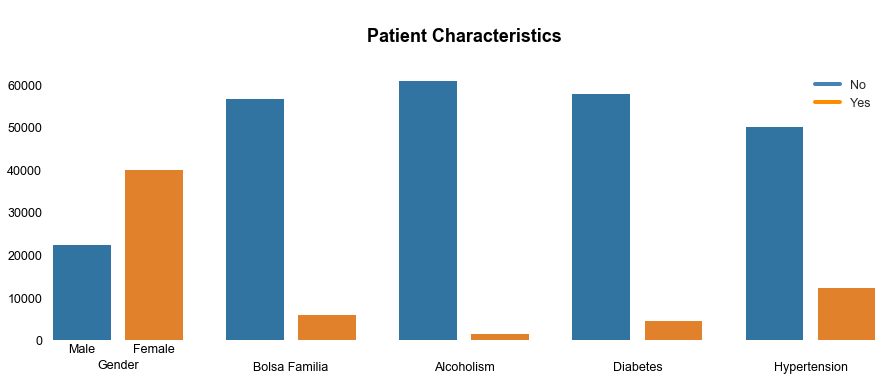

In [9]:
# Plot binary patient characteristics
fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 5, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = unique_patients)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['', ''])
        ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\nPatient Characteristics\n', fontsize = 18, fontweight = 'bold')
    i += 1

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [10]:
fields = ['Women', 'Bolsa Familia', 'Alcoholic', 'Diabetes', 'Hypertension']
char_props = [round(unique_patients['Gender'].mean(), 3),
              round(unique_patients['BolsaFamilia'].mean(), 3),
              round(unique_patients['Alcoholism'].mean(), 3),
              round(unique_patients['Diabetes'].mean(), 3),
              round(unique_patients['Hypertension'].mean(), 3)]

pd.DataFrame(char_props, index = fields, columns = ['Proportion'])

,Proportion
Women,0.643
Bolsa Familia,0.093
Alcoholic,0.024
Diabetes,0.071
Hypertension,0.197


In [11]:
# Average number of appointments per patient
round(df.groupby('PatientID')['AppointmentID'].count().mean(), 2)

1.63

Almost 65% of the patients in the data set are women, which fits the stereotype that men avoid going to the doctor.

#### Age

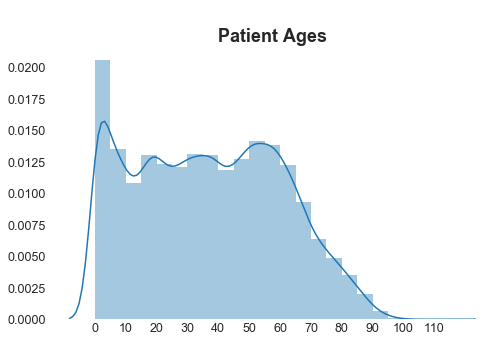

In [12]:
# Only plot the average age for each unique patient that appears in the dataset
fig = plt.figure(figsize = (8, 5))
sns.distplot(unique_patients['Age'], bins=list(range(0, 120, 5)))
sns.despine(left = True, bottom = True)
plt.title('\nPatient Ages', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.xticks(np.arange(0, 120, 10))
plt.show();

In [13]:
bins = [0, 11, 21, 41, 61, 81, 100, 116]
bin_names = ["0-10", "11-20", "21-40", "41-60", "61-80", "81-99", "100+"]

ages_bins = pd.cut(unique_patients['Age'], bins = bins, labels = bin_names).value_counts()
ages_bins.sort_index()

0-10      9984
11-20     7608
21-40    15653
41-60    16452
61-80     9130
81-99     1439
100+         4
Name: Age, dtype: int64

In [14]:
df['Age'].describe()

count    101803.000000
mean         37.059900
std          23.214054
min           0.000000
25%          18.000000
50%          37.000000
75%          56.000000
max         115.000000
Name: Age, dtype: float64

A significant number of the patients are children aged from 0 to 5.  The ages are fairly uniform from 6 to 65, after which the number of patients decreases somewhat linearly.

#### Handicaps

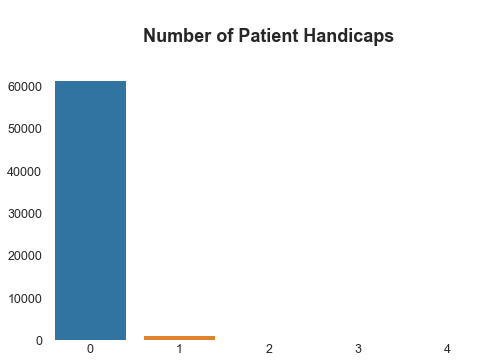

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(unique_patients['NumHandicaps'])
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['0', '1', '2', '3', '4'])
plt.show();

In [16]:
unique_patients['NumHandicaps'].value_counts()

0.0    61165
1.0     1025
2.0       99
3.0        6
4.0        3
Name: NumHandicaps, dtype: int64

In [17]:
round(unique_patients['NumHandicaps'].mean(), 3)

0.02

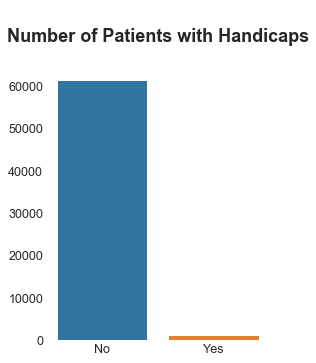

In [18]:
fig, ax = plt.subplots(figsize = (4, 5))
sns.countplot(unique_patients['HasHandicaps'])
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Patients with Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['No', 'Yes'])
plt.show();

The vast majority of patients do not have handicaps, but of those that do most only have one.

#### Appointments by Day

In [19]:
df['AppointmentDay'].value_counts().sort_index().resample('D').sum()

2016-04-29    2979
2016-04-30       0
2016-05-01       0
2016-05-02    4056
2016-05-03    3960
2016-05-04    3828
2016-05-05    3984
2016-05-06    3535
2016-05-07       0
2016-05-08       0
2016-05-09    4164
2016-05-10    3960
2016-05-11    4162
2016-05-12    4083
2016-05-13    3568
2016-05-14      38
2016-05-15       0
2016-05-16    4238
2016-05-17    4069
2016-05-18    4029
2016-05-19    3931
2016-05-20    3484
2016-05-21       0
2016-05-22       0
2016-05-23       0
2016-05-24    3692
2016-05-25    3566
2016-05-26       0
2016-05-27       0
2016-05-28       0
2016-05-29       0
2016-05-30    4139
2016-05-31    3956
2016-06-01    4088
2016-06-02    4014
2016-06-03    3766
2016-06-04       0
2016-06-05       0
2016-06-06    4300
2016-06-07    4098
2016-06-08    4116
Freq: D, Name: AppointmentDay, dtype: int64

There were only 38 appointments on the weekend, all occurring on Saturday, May 14th.  Besides the weekends, there were no appointments on Monday, May 23; Thursday, May 26; or Friday, May 27.

May 26 was the optional holiday of Corpus Christi, however I couldn't find any reason as to why there is no data for the 23rd or 27th.

In [20]:
df['Weekend'].sum()

38

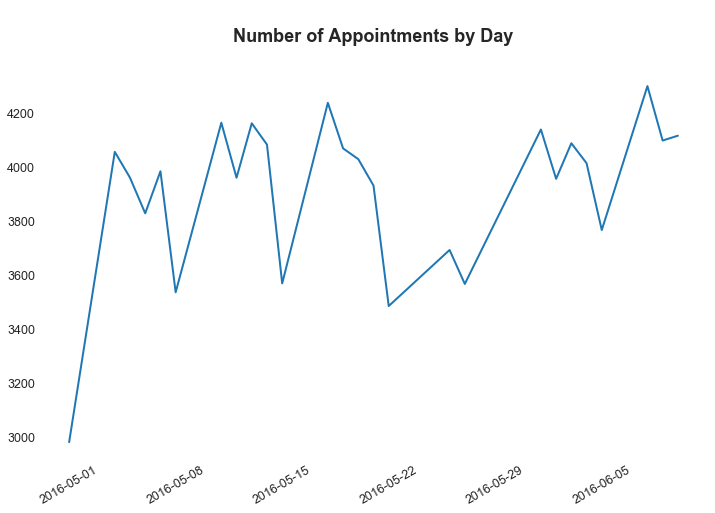

In [21]:
# Exclude weekends and weekdays with no appointments
fig = plt.figure(figsize = (12, 8))
no_weekends = df[df['Weekend'] == 0]
appt_by_day = no_weekends.groupby('AppointmentDay')['AppointmentDay'].count()
appt_by_day.plot(linewidth = 2)
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Appointments by Day\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('');

The weekends and weekdays with no appointments were excluded from the graph in order to focus more on the normal fluctuations without the low outliers affecting the graph.

In [22]:
# Average number of appointments per day (on non-zero days and weekdays)
round(df[df['Weekend'] == 0]['AppointmentDay'].value_counts().mean(), 2)

3914.04

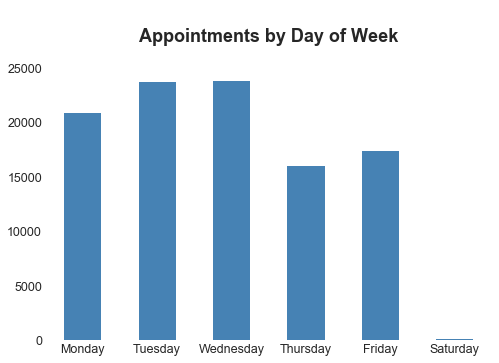

In [23]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, ax = plt.subplots(figsize = (8, 5))
df['DayOfWeek'].value_counts().sort_index().plot(ax = ax, kind = 'bar', color = 'steelblue')
ax.set(xticklabels = days_of_week)
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.title('\nAppointments by Day of Week\n', fontsize = 18, fontweight = 'bold');

The appointments started on Friday, April 29 and ended on Wednesday, June 8.  Hence there are not an equal number of weekdays in the dataset; there are appointments on five Thursdays, but six on every other weekday.  On the line graph, we can clearly see a peak occuring each Monday, and a dip occurring each Friday.  There isn't a consistent pattern for the number of appointments on Tuesdays, Wednesdays, and Thursdays, besides that they have less than or equal to Mondays, and more than Fridays.

#### Appointments By Day Scheduled

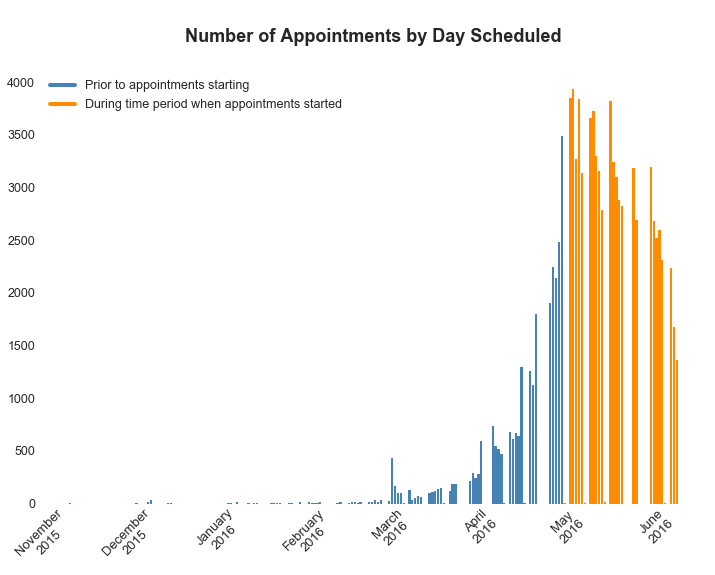

In [24]:
sched_date_counts = df.groupby('ScheduledDayDate')['ScheduledDayDate'].count()

# Find index of first scheduled date that is an appointment date
sched_len = len(sched_date_counts)
first_ix = list(sched_date_counts.index > df['AppointmentDayDate'].min()).index(True)

# Use orange for the appointments scheduled during the time period that
# the appointments took place
colors = ['steelblue'] * first_ix
colors.extend(['darkorange'] * (sched_len-first_ix))

fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(sched_date_counts.index, sched_date_counts, color = colors)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B\n%Y'))

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['Prior to appointments starting',
                         'During time period when appointments started'])

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 45, fontsize = 13)
plt.title('\nNumber of Appointments by Day Scheduled\n', fontsize = 18, fontweight = 'bold');

In [25]:
# Proportion of appointments that were scheduled during the time period that
# the appointments took place
float('{:0.3f}'.format(sched_date_counts[first_ix:].sum()/sched_date_counts.sum()))

0.736

The vast majority of appointments were made during the two weeks that the appointments were scheduled for.  Additionally, the closer to the appointments we get, the more appointments were scheduled. 

#### Appointments By Hour Scheduled

In [26]:
hour_counts = df['ScheduledHour'].value_counts()
hour_counts.sort_index()

6        25
7     10940
8     15904
9     12770
10    10841
11     9135
12     5818
13     6272
14     9015
15     7811
16     6575
17     3822
18     1865
19      755
20      230
21       25
Name: ScheduledHour, dtype: int64

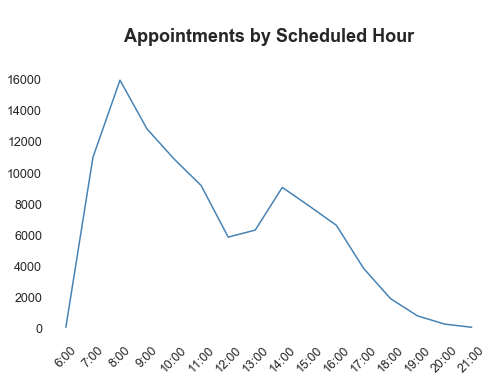

In [27]:
fig, ax = plt.subplots(figsize = (8, 5))
hour_counts.sort_index().plot(kind = 'line', color = 'steelblue')
sns.despine(left = True, bottom = True)

formatted_hours = [str(hour) + ':00' for hour in range(6, 22)]
plt.xticks(np.arange(6, 22, 1), rotation = 45)
ax.set(xticklabels=formatted_hours)
plt.title('\nAppointments by Scheduled Hour\n', fontsize = 18, fontweight = 'bold');

We can clearly see that the majority of appointments were made before 11am, with a smaller spike around 2pm, at which time it also begins monotonically decreasing.

#### Neighborhoods

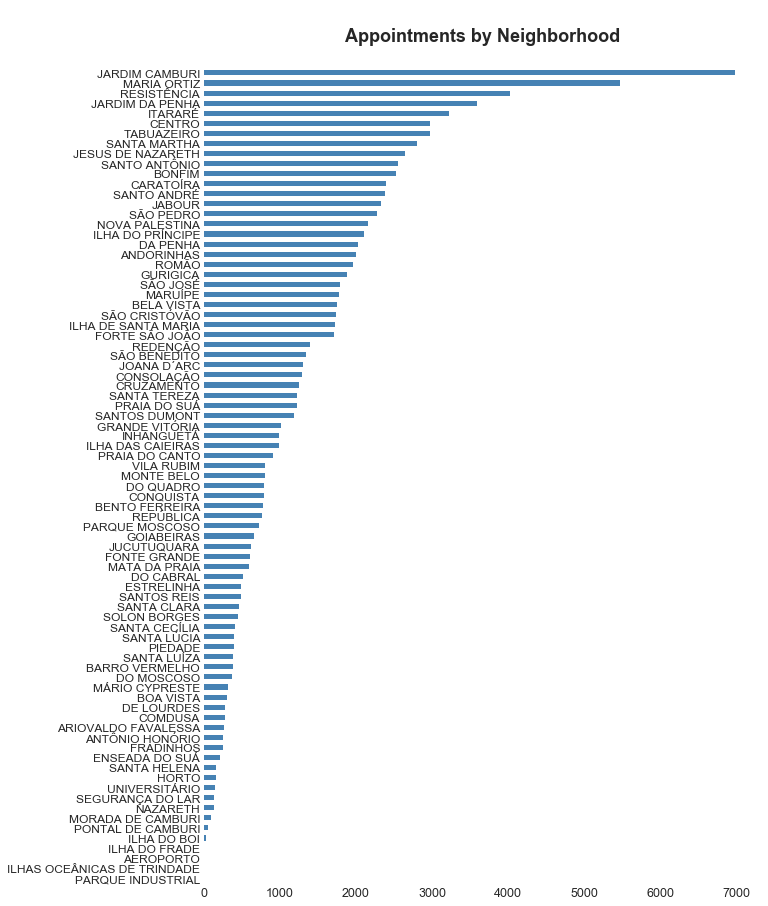

In [28]:
neighborhood_counts = df['Neighborhood'].value_counts()

fig, ax = plt.subplots(figsize = (10, 15))
neighborhood_counts.sort_values().plot(kind = 'barh', color = 'steelblue')
sns.despine(left = True, bottom = True)
plt.yticks(fontsize = 12)
plt.title('\nAppointments by Neighborhood\n', fontsize = 18, fontweight = 'bold');

There is a great discrepancy in the number of appointments in the different neighborhoods; one neighborhood has almost 7000 appointments while there are four neighborhoods with ten or fewer appointments.

In [29]:
neighborhood_df = pd.DataFrame(neighborhood_counts).reset_index().rename(columns = {'index': 'neighborhood',
                                                                                    'Neighborhood': 'count'})
# join neighborhood_counts with geo dataframe
neighborhood_lat_lng = pd.merge(neighborhood_df, geo[['neighborhood', 'lat', 'lng']], on = 'neighborhood')

# convert counts to proportions
neighborhood_lat_lng['prop'] = neighborhood_lat_lng['count']/len(df)
neighborhood_lat_lng.head()

,neighborhood,count,lat,lng,prop
0,JARDIM CAMBURI,6978,-20.265020,-40.264420,0.068544
1,MARIA ORTIZ,5464,-20.258221,-40.297482,0.053672
2,RESISTÊNCIA,4025,-20.270830,-40.320320,0.039537
3,JARDIM DA PENHA,3587,-20.284531,-40.294998,0.035235
4,ITARARÉ,3226,-20.295549,-40.305199,0.031689


In [30]:
hood_lst = neighborhood_lat_lng[['lat', 'lng', 'prop']].values.tolist() # need to pass list to folium

m = folium.Map(location=[-20.292474, -40.317893], tiles='stamentoner', zoom_start = 13)
m.add_child(folium.plugins.HeatMap(hood_lst))

#### SMS Received and No-Shows

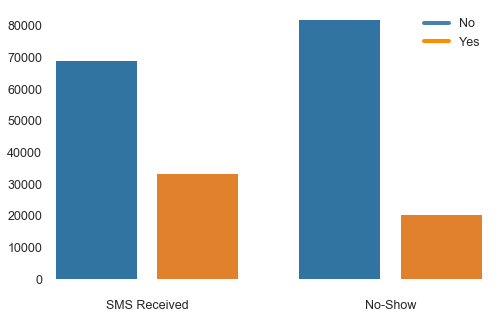

In [31]:
# Plot binary appointment characteristics
fields = ['SMSReceived', 'NoShow']
xlabels = ['SMS Received', 'No-Show']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 2, figsize = (8, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = fields[i], data = df)
    sns.set_style("white")
    ax.tick_params(length = 0)
    sns.despine(left = True, bottom = True)
    ax.set(xticklabels=['', ''])
    ax.set(xlabel = '\n' + xlabels[i], ylabel = '')
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=4),
                Line2D([0], [0], color = 'darkorange', lw=4)]
ax.legend(custom_lines, ['No', 'Yes'])
plt.show()

In [32]:
# Proportion of sms received
round(df['SMSReceived'].mean(), 3)

0.325

In [33]:
# Proportion of no-shows
no_show_rate = df['NoShow'].mean()
round(no_show_rate, 3)

0.197

#### Number of Times an Appointment was Scheduled

In [34]:
df['NumTimesScheduled'].describe()

count    101803.000000
mean          1.085636
std           0.332597
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: NumTimesScheduled, dtype: float64

In [35]:
# Append missing values from value_counts index
missing_times_sched = pd.Series([0, 0], index = [7, 9])
missing_times_sched

num_times_sched = (df['NumTimesScheduled'].value_counts()).append(missing_times_sched).\
                   sort_index()

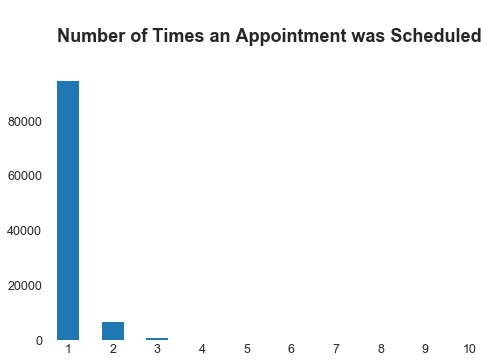

In [36]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = '#1f77b4')

plt.xticks(rotation = 0)
plt.ylabel('')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold');

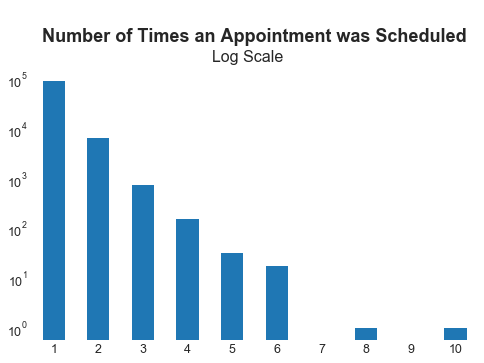

In [37]:
fig, ax = plt.subplots(figsize = (8, 5))
num_times_sched.plot(kind = 'bar', color = '#1f77b4')

plt.xticks(rotation = 0)
plt.ylabel('')
ax.set_yscale('log')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

In [38]:
round(len(df[df['NumTimesScheduled'] == 1])/len(df), 3)

0.927

Almost 93% of the appointments were only scheduled once, but there are appointments that were rescheduled up to nine times.  The data is skewed to the right.  We can see the magnitudinal differences in the number of schedulings in the log scale plot.  The data is still skewed to the right even after the log transform.

In [39]:
# Create dictionary of sorting order
num_sched_sorter = dict(zip(num_sched_labels, range(len(num_sched_labels))))
num_sched_df = df['NumSchedBin'].value_counts().reset_index()

# Create a column of the sorting order
num_sched_df['sort_order'] = num_sched_df['index'].map(num_sched_sorter)
num_sched_df.sort_values(by = 'sort_order')
num_sched_df

NameError: name 'num_sched_labels' is not defined

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(ax = ax, x = 'sort_order', y = 'NumSchedBin', data = num_sched_df,
            color = '#1f77b4')

ax.set(xticklabels = num_sched_labels)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
sns.despine(left = True, bottom = True)
plt.title('\nNumber of Times an Appointment was Scheduled\n', fontsize = 18, fontweight = 'bold');

#### Days Between Scheduling and Appointment

In [40]:
df['DayDiff'].describe()

count    101803.000000
mean         10.084408
std          15.177670
min           0.000000
25%           0.000000
50%           4.000000
75%          14.000000
max         179.000000
Name: DayDiff, dtype: float64

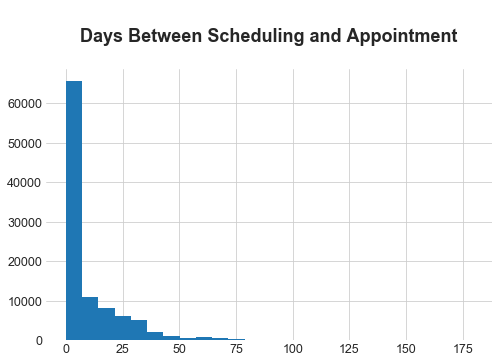

In [41]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.show();

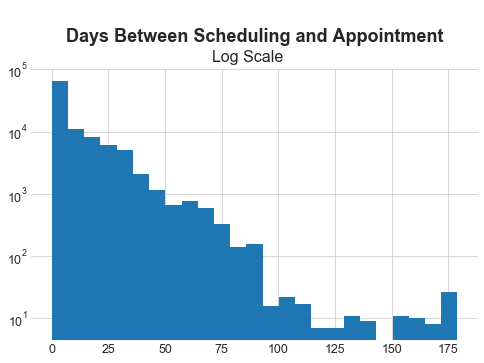

In [42]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DayDiff'].hist(bins = 25)
sns.despine(left = True, bottom = True)
ax.set_yscale('log')
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);
plt.show();

In [43]:
# Proportion of appointments scheduled on the same day as the appointment
float('{:0.3f}'.format((df['DayDiff'] == 0).sum()/len(df)))

0.347

In [44]:
### DELETE THIS LATER
day_diff_bin_labels = ['0', '1-2', '3-5', '6-10', '11-14', '15-29', '30-59', '60+']

In [45]:
# Create dictionary of sorting order
day_diff_sorter = dict(zip(day_diff_bin_labels, range(len(day_diff_bin_labels))))
day_diff_df = df['DayDiffBin'].value_counts().reset_index()

# Create a column of the sorting order
day_diff_df['sort_order'] = day_diff_df['index'].map(day_diff_sorter)
day_diff_df.sort_values(by = 'sort_order')
day_diff_df

,index,DayDiffBin,sort_order
0,0,35280,0
1,15-29,15213,5
2,6-10,13153,3
3,1-2,11349,1
4,3-5,10660,2
5,30-59,8090,6
6,11-14,6100,4
7,60+,1958,7


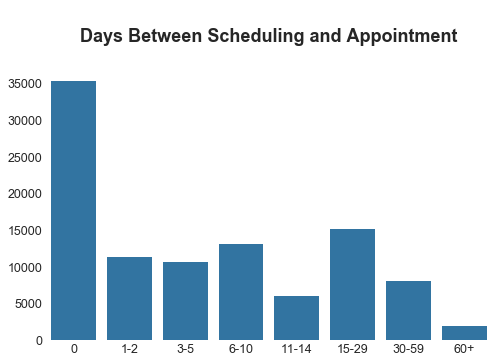

In [46]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.despine(left = True, bottom = True)
sns.barplot(ax = ax, x = 'sort_order', y = 'DayDiffBin', data = day_diff_df,
           color = '#1f77b4')
ax.set(xticklabels = day_diff_bin_labels)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation = 0)
plt.title('\nDays Between Scheduling and Appointment\n', fontsize = 18, fontweight = 'bold')
plt.show();

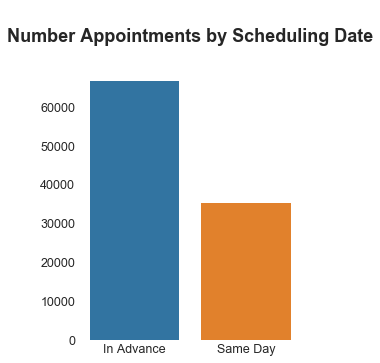

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (4, 5))

sns.countplot(ax = ax, x = 'SameDayAppt', data = df)
sns.set_style("white")
ax.tick_params(length = 0)
sns.despine(left = True, bottom = True)
ax.set(xticklabels=['In Advance', 'Same Day'])
ax.set(xlabel = '')
ax.set(ylabel = '')
plt.title('\nNumber Appointments by Scheduling Date\n', fontsize = 18, fontweight = 'bold')
    
plt.show()

About 35% of the appointments were made on the same day as the appointment.  Very few appointments were made more than a month in advance.

#### Days Between Rescheduling

In [48]:
df['DaysBWScheduling'].describe()

count    101803.000000
mean          0.408667
std           3.721975
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         134.040833
Name: DaysBWScheduling, dtype: float64

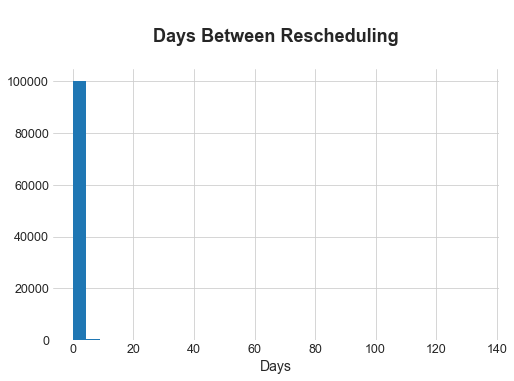

In [49]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 30)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nDays Between Rescheduling\n', fontsize = 18, fontweight = 'bold');

From the plots of NumTimesScheduled, we know that 93% of the appointments were made once (i.e. were not rescheduled), and hence there are zero days between the original scheduling and the rescheduling of the appointment.

In [50]:
# Differences that are greater than 0
diff_greater_0 = df.query('DaysBWScheduling > 0')['DaysBWScheduling']
diff_greater_0.describe()

count    6315.000000
mean        6.588043
std        13.514442
min         0.000012
25%         0.007373
50%         0.191690
75%         6.905104
max       134.040833
Name: DaysBWScheduling, dtype: float64

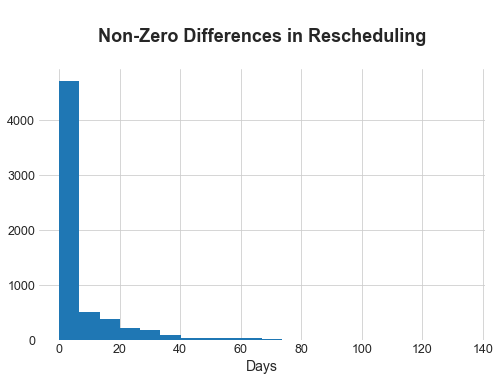

In [51]:
fig, ax = plt.subplots(figsize = (8, 5))
diff_greater_0.hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
plt.title('\nNon-Zero Differences in Rescheduling\n', fontsize = 18, fontweight = 'bold');

Most of the appointments that were rescheduled were scheduled later on the same day as the original scheduling.

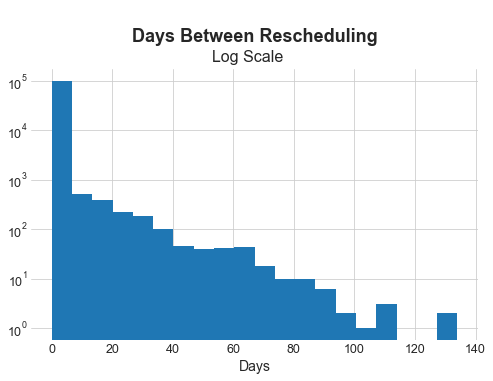

In [52]:
fig, ax = plt.subplots(figsize = (8, 5))
df['DaysBWScheduling'].hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.xlabel('Days', fontsize = 14)
ax.set_yscale('log')
plt.title('\nDays Between Rescheduling\n', fontsize = 18, fontweight = 'bold')
plt.suptitle('\nLog Scale\n', fontsize = 16);

The data was skewed to the right using a normal scale, and it remains positively skewed after using a log scale.

In [53]:
# DELETE LATER
day_bw_labels = ['0', '<1', '1-2', '3-5', '6-10', '11-14', '15-29', '30+']

In [54]:
# Create dictionary of sorting order
day_bw_sorter = dict(zip(day_bw_labels, range(len(day_bw_labels))))
day_bw_df = df['DayBWBin'].value_counts().reset_index()

# Create a column of the sorting order
day_bw_df['sort_order'] = day_bw_df['index'].map(day_bw_sorter)
day_bw_df.sort_values(by = 'sort_order')
day_bw_df

,index,DayBWBin,sort_order
0,0,95488,0
1,<1,3871,1
2,15-29,571,6
3,6-10,454,4
4,3-5,390,3
5,30+,388,7
6,1-2,360,2
7,11-14,281,5


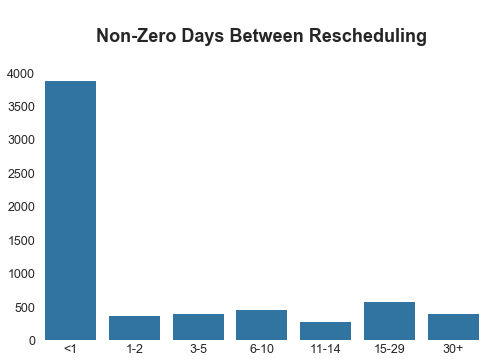

In [55]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.despine(left = True, bottom = True)
sns.barplot(ax = ax, x = 'sort_order', y = 'DayBWBin',
            data = day_bw_df[1:],
            color = '#1f77b4')
ax.set(xticklabels = day_bw_labels[1:])
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
plt.title('\nNon-Zero Days Between Rescheduling\n', fontsize = 18, fontweight = 'bold')
plt.show();

#### Prior Attendance Record

In [56]:
df['PriorAttendanceRecord'].describe()

count    39505.000000
mean         0.778644
std          0.365464
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: PriorAttendanceRecord, dtype: float64

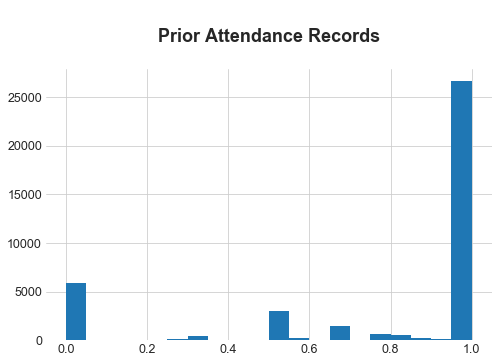

In [57]:
fig, ax = plt.subplots(figsize = (8, 5))
df['PriorAttendanceRecord'].hist(bins = 20)
sns.despine(left = True, bottom = True)
plt.title('\nPrior Attendance Records\n', fontsize = 18, fontweight = 'bold');

Patients that made more than one appointment are the only patients with prior attendance records.  The overwhelming majority of these appointments were made with prior attendance records around 1, i.e. near or perfect attendance.  There is also a smaller spike for the values around 0 for patients that have never, or rarely, attended prior appointments.  There are few values that are not at the extremes, the most common being around 0.5.

#### Shows in a Row

In [58]:
df['ShowsInARow'].describe()

count    101803.000000
mean          0.454053
std           1.170600
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
Name: ShowsInARow, dtype: float64

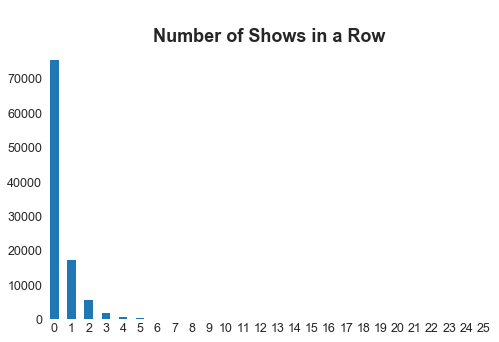

In [59]:
fig, ax = plt.subplots(figsize = (8, 5))
df['ShowsInARow'].value_counts().plot(kind = 'bar', color = '#1f77b4')
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.title('\nNumber of Shows in a Row', fontsize = 18, fontweight = 'bold');

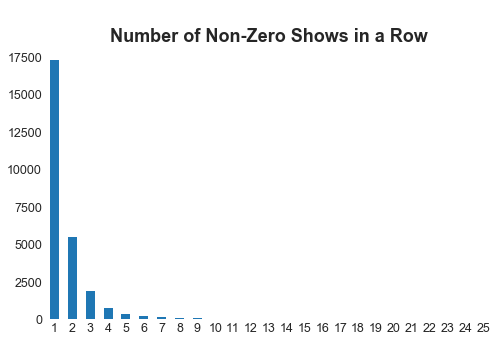

In [60]:
fig, ax = plt.subplots(figsize = (8, 5))
df['ShowsInARow'].value_counts()[1:].plot(kind = 'bar', color = '#1f77b4')
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.title('\nNumber of Non-Zero Shows in a Row', fontsize = 18, fontweight = 'bold');

The majority of appointments were made with the patient either not having any prior appointments or with their last appointment a no-show.  Most of those that do have a string of attended appointments do not have more than one.

#### Weather

In [61]:
# Number of rainy days
weather['rain'].sum()

6

In [62]:
# Number of days with thunderstorms
weather['thunderstorm'].sum()

2

In [63]:
# Number of days with fog
weather['fog'].sum()

1

In [64]:
# Add field for formatted dates for plots
weather['FormattedDate'] = weather['Datetime'].dt.strftime("%B %-d")

##### Precipitation

In [65]:
# Number of days with more than 0 in. precipitation
(weather['precip_in'] > 0).sum()

5

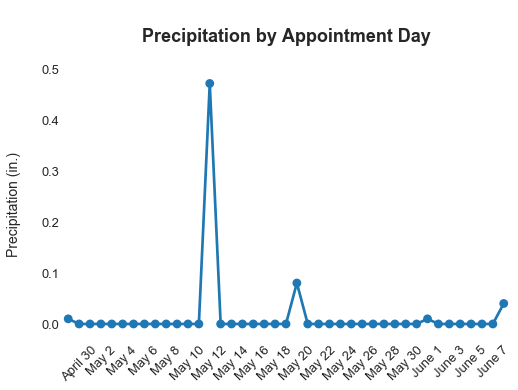

In [66]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'precip_in', data = weather)
sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.ylabel('Precipitation (in.)\n', fontsize = 14)
plt.yticks(fontsize = 13)
plt.title('\nPrecipitation by Appointment Day\n', fontsize = 18, fontweight = 'bold')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()

The weather was very good during the 40-day span that the appointments took place.  There were only a few days of rain and thunderstorms, and only one day with fog.

##### Temperature

In [67]:
# Create temps dataframe in long format for plot
temps = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['temp_high', 'temp_avg', 'temp_low'],
                var_name = 'Name',
                value_name= 'Temperature')

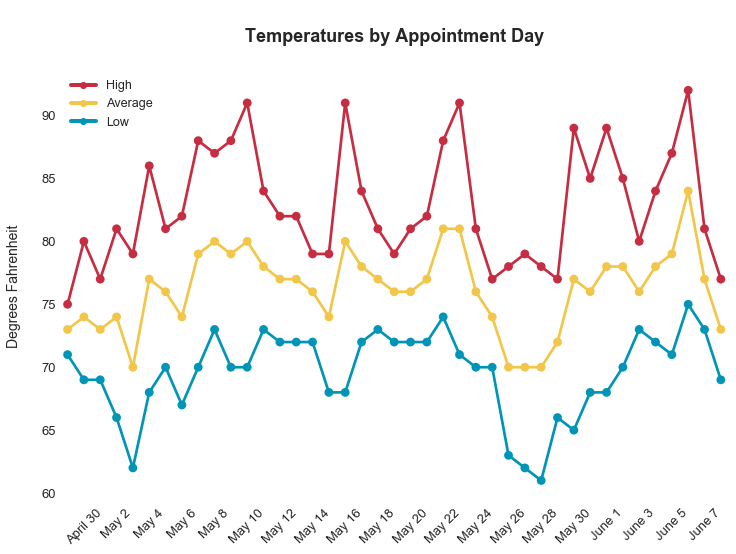

In [68]:
fig, ax = plt.subplots(figsize = (12, 8))

custom = ['#C62D42', '#F2C649', '#0095B7']
sns.set_palette(custom)

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Temperature', hue = 'Name', data = temps)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Degrees Fahrenheit\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nTemperatures by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [69]:
pd.concat([weather['temp_low'].describe(),
           weather['temp_avg'].describe(),
           weather['temp_high'].describe()],
           axis=1)

,temp_low,temp_avg,temp_high
count,41.000000,41.000000,41.000000
mean,69.560976,76.219512,82.853659
std,3.391525,3.244320,4.623640
min,61.000000,70.000000,75.000000
25%,68.000000,74.000000,79.000000
50%,70.000000,77.000000,82.000000
75%,72.000000,78.000000,87.000000
max,75.000000,84.000000,92.000000


The temperature each day never got lower than 60, and was never higher than 92.  Most days the average temperature was in the mid-seventies.

##### Humidity

In [70]:
# Create humidity dataframe in long format for plot
humidity = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['humidity_high', 'humidity_avg', 'humidity_low'],
                var_name = 'Name',
                value_name= 'Humidity')

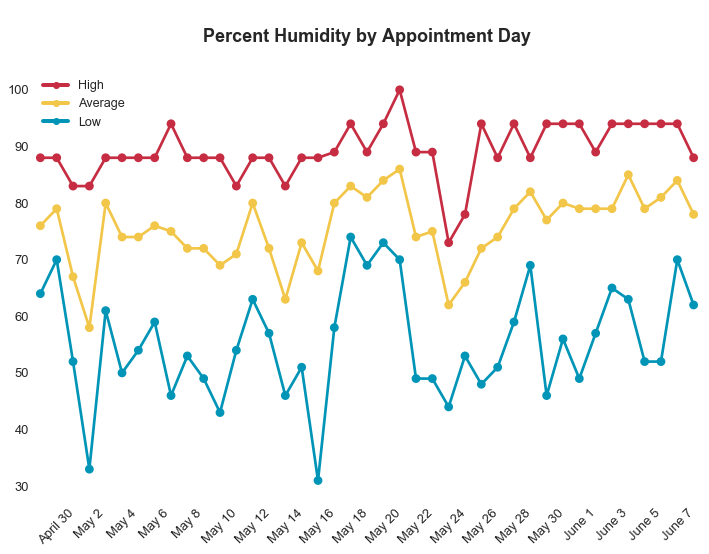

In [71]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Humidity', hue = 'Name', data = humidity)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'], loc=2)

plt.title('\nPercent Humidity by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [72]:
pd.concat([weather['humidity_low'].describe(),
           weather['humidity_avg'].describe(),
           weather['humidity_high'].describe()],
           axis=1)

,humidity_low,humidity_avg,humidity_high
count,41.000000,41.000000,41.000000
mean,55.463415,75.560976,89.219512
std,10.052606,6.438357,4.952334
min,31.000000,58.000000,73.000000
25%,49.000000,72.000000,88.000000
50%,54.000000,76.000000,88.000000
75%,63.000000,80.000000,94.000000
max,74.000000,86.000000,100.000000


Humidity fluctuated a lot within each day; on some days the humidity ranged from around 30% to about 90%. Normally the humidity went from around 50% to 90%.

##### Visibility

In [73]:
# Create humidity dataframe in long format for plot
visibility = pd.melt(weather, id_vars = ['FormattedDate'],
                     value_vars=['visibility_high', 'visibility_avg', 'visibility_low'],
                     var_name = 'Name',
                     value_name= 'Visibility')

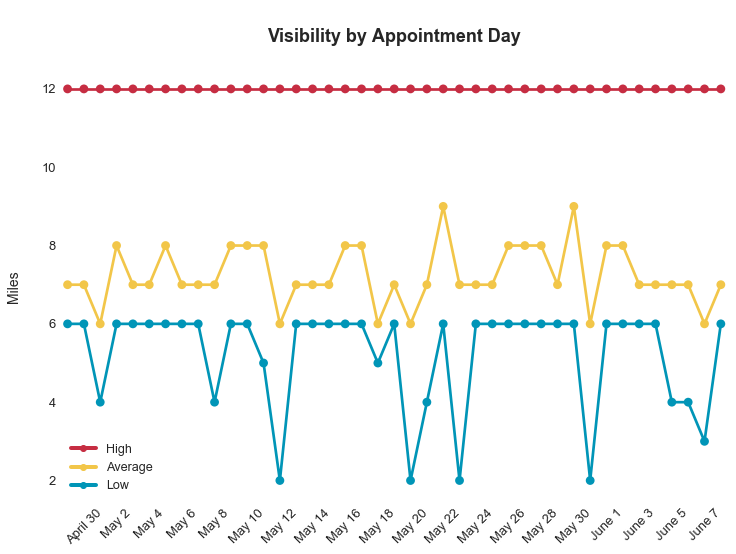

In [74]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Visibility', hue = 'Name', data = visibility)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Miles\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4),
                Line2D([0], [0], marker='o', color = '#0095B7', lw=4)]
ax.legend(custom_lines, ['High', 'Average', 'Low'])

plt.title('\nVisibility by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [75]:
pd.concat([weather['visibility_low'].describe(),
           weather['visibility_avg'].describe(),
           weather['visibility_high'].describe()],
           axis=1)

,visibility_low,visibility_avg,visibility_high
count,41.000000,41.000000,41.0
mean,5.243902,7.243902,12.0
std,1.337544,0.767479,0.0
min,2.000000,6.000000,12.0
25%,5.000000,7.000000,12.0
50%,6.000000,7.000000,12.0
75%,6.000000,8.000000,12.0
max,6.000000,9.000000,12.0


The visibility was always at least 2 miles, and the high was always 12 miles.  The average visibility has a lower standard deviation and was mostly from 6 to 8 miles.

##### Wind

In [76]:
wind = pd.melt(weather, id_vars = ['FormattedDate'],
                value_vars=['wind_high', 'wind_avg'],
                var_name = 'Name',
                value_name= 'Wind')

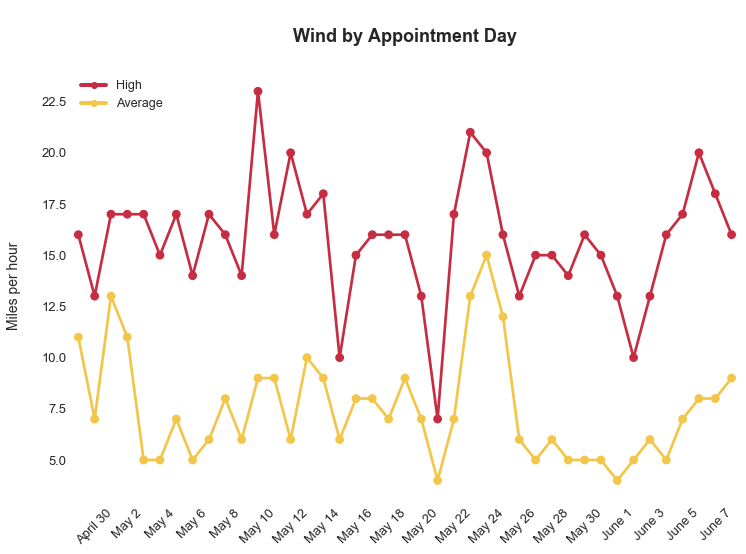

In [77]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.pointplot(ax = ax, x = 'FormattedDate', y = 'Wind', hue = 'Name', data = wind)
sns.despine(left = True, bottom = True)

plt.xlabel('')
plt.xticks(rotation = 45, fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Miles per hour\n', fontsize = 14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

custom_lines = [Line2D([0], [0], marker='o', color = '#C62D42', lw=4),
                Line2D([0], [0], marker='o', color = '#F2C649', lw=4)]
ax.legend(custom_lines, ['High', 'Average'], loc=2)

plt.title('\nWind by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.show()

In [78]:
pd.concat([weather['wind_avg'].describe(),
           weather['wind_high'].describe()],
           axis=1)

,wind_avg,wind_high
count,41.000000,41.000000
mean,7.487805,15.731707
std,2.637441,2.958246
min,4.000000,7.000000
25%,5.000000,14.000000
50%,7.000000,16.000000
75%,9.000000,17.000000
max,15.000000,23.000000


According to the [National Weather Service](https://www.weather.gov/bgm/forecast_terms), 15-25 mph is breezy and 20-30 mph is windy.  The average wind each day is considered "no wind," while the high is normally considered breezy. 

<a id='by_attendance'></a>

### By Attendance

In [79]:
# Create separate dataframes for no-shows and shows
no_shows = df[df['NoShow'] == 1]
shows = df[df['NoShow'] == 0]

#### Patient Characteristics & SMS Received

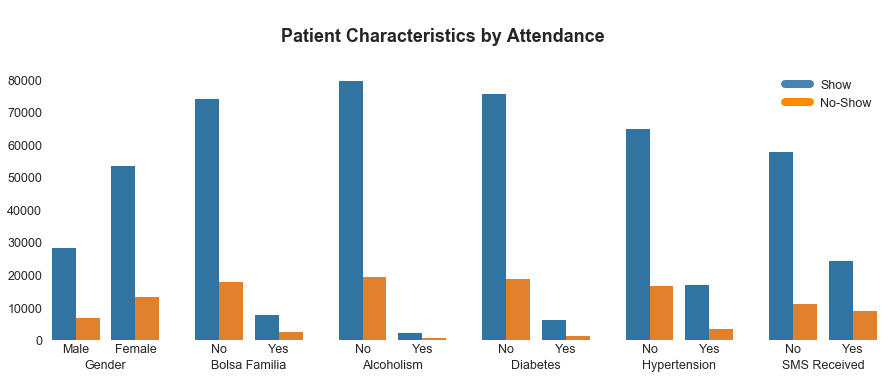

In [122]:
# Plot binary patient characteristics & SMS Received by attendance - not aggregated (by individual appointment)
sns.set_palette("tab10")

char_fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 'SMSReceived']
xlabels = ['Gender', 'Bolsa Familia', 'Alcoholism', 'Diabetes', 'Hypertension', 'SMS Received']
gender_labels = ['Male', 'Female']
labels = ['No', 'Yes']

fig, axes = plt.subplots(1, 6, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.countplot(ax = ax, x = char_fields[i], hue = 'NoShow', data = df)
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\n' + ' '*20 + 'Patient Characteristics by Attendance\n', fontsize = 18, fontweight = 'bold')
    
    i += 1
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=8),
                Line2D([0], [0], color = 'darkorange', lw=8)]
ax.legend(custom_lines, ['Show', 'No-Show'])
plt.show()

In [144]:
prop_fields = ['Gender', 'BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 
               'SMSReceived', 'NumHandicaps', 'DayOfWeek', 'Neighborhood',
               'NumTimesScheduled', 'NumSchedBin', 'DayDiffBin', 'DayBWBin', 'rain', 'thunderstorm',
               'fog', 'precip_in', 'humidity_low', 'humidity_high', 'humidity_avg', 'visibility_low',
               'wind_avg', 'wind_high', 'temp_high', 'temp_low', 'temp_avg', 'DayOfWeek',
               'Weekend', 'HasHandicaps', 'PriorAttendanceRecord', 'ShowsInARow', 'SameDayAppt',
               'WasRescheduled']

# create dictionary of dataframes of proportions of no-shows for each field
no_show_props = {}
for field in prop_fields:
    no_show_props[field] = (df.groupby([field,'NoShow'])['NoShow'].count()/
                            df.groupby(field)['NoShow'].count()).rename('prop').reset_index()
    no_show_props[field] = no_show_props[field][no_show_props[field]['NoShow'] == 1] # only keep no-shows

# create dictionary of dataframes of frequencies of no-shows for each field as arrays for graph labels
freqs_labels = {}
for field in prop_fields:
    counts = df.groupby([field,'NoShow'])['NoShow'].count().rename('count').reset_index()
    # only keep no-shows
    counts = counts[counts['NoShow'] == 1]
    freqs_labels[field] = np.array(counts['count'])
    
freq_fields = ['BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension', 
               'SMSReceived', 'HasHandicaps', 'SameDayAppt', 'WasRescheduled',
               'thunderstorm', 'fog']

# create dictionary of dataframes of frequencies of no-shows for each field as arrays for
# chi-square test
no_show_freqs = {}
for field in freq_fields:
    no_show_freqs[field] = pd.crosstab(df[field], df['NoShow']).values

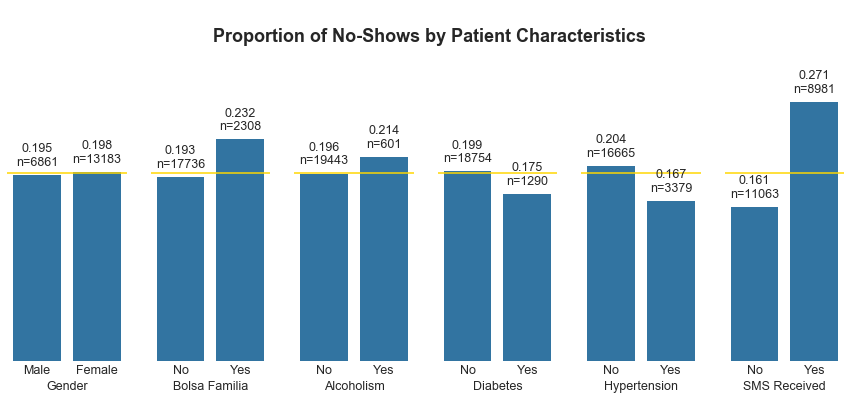

In [126]:
# Plot proportion of no-shows by binary patient characteristics
fig, axes = plt.subplots(1, 6, figsize = (15, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.barplot(ax = ax, x = char_fields[i], y = 'prop', hue = 'NoShow', data = no_show_props[char_fields[i]]);
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    ax.set(yticklabels='')
    if i == 0:
        ax.set(xticklabels=['Male', 'Female'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    else:
        ax.set(xticklabels=['No', 'Yes'])
        ax.set(xlabel = xlabels[i], ylabel = '')
    if i == 2:
        ax.set_title('\n' + ' '*30 + 'Proportion of No-Shows by Patient Characteristics\n\n', fontsize = 18,
                     fontweight = 'bold')
    
    ax.axhline(y=no_show_rate, color = 'gold')

    j = 0
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01,
                '{:0.3f}\nn={}'.format(height, freqs_labels[char_fields[i]][j]),
                ha="center")
        j +=1
    i += 1

plt.show()

There is a very minute difference between the no-show rates for men and women, but the other attributes show a more clear difference.  The most dramatic discrepancy is between those that received a text reminder (SMS) and those that did not; patients that received an SMS were about 1.68 times more likely to not attend their appointment.  This seems to go against logic, since one would expect a reminder to make you less likely to miss your appointment.  Any lurking variables responsible for this relationship, will be explored later.

We can also see that patients receiving government assistance through the Bolsa Familia program are more likely to miss appointments than those not a part of the program.  Those with diabetes and hypertension are more likely than their counterparts to attend appointments, probably since it is important for these patients to manage their chronic conditions.

#### Age

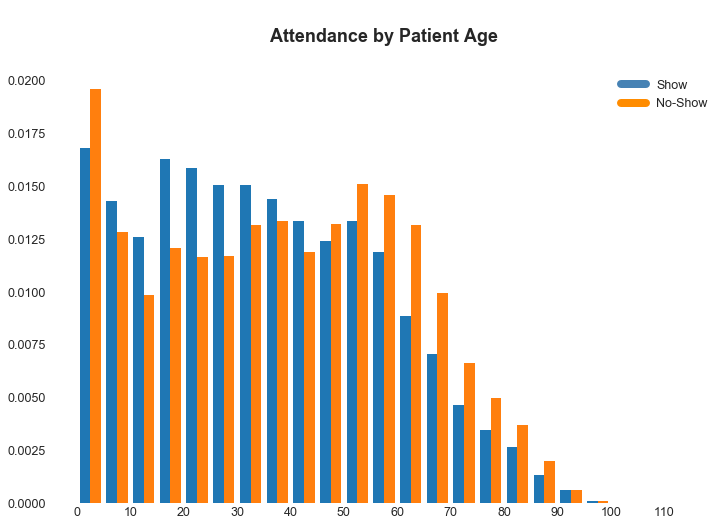

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist([no_shows['Age'].values, shows['Age'].values], bins=list(range(0, 120, 5)), normed=True)
sns.despine(left = True, bottom = True)
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=8),
                Line2D([0], [0], color = 'darkorange', lw=8)]
ax.legend(custom_lines, ['Show', 'No-Show'])
plt.title('\nAttendance by Patient Age\n', fontsize = 18, fontweight = 'bold')
plt.xticks(np.arange(0, 120, 10))
plt.show();

The youngest age group, from 0-5 years old, has a greater rate of no-shows than any other age group.  Howver starting after this group until age 45, the age groups have a greater rate of shows than no-shows.  After age 45, all of the age groups have a greater incidence of no-shows.  Apart from young children, patients younger than middle age are more likely to attend appointments, while older patients are more likely to skip.

#### Handicaps

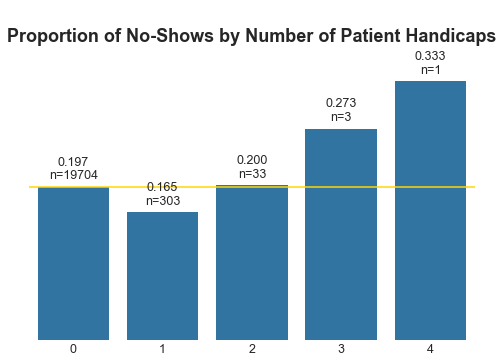

In [91]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
sns.barplot(x = 'NumHandicaps', y = 'prop', data = no_show_props['NumHandicaps'], color = '#1f77b4');
sns.despine(left = True, bottom = True)
plt.title('\nProportion of No-Shows by Number of Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{:0.3f}\nn={}'.format(height, freqs_labels['NumHandicaps'][j]),
            ha="center")
    j +=1
    
plt.show();

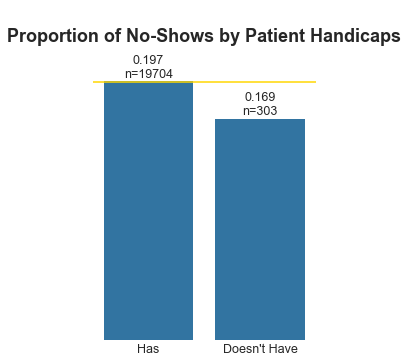

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (4, 5))
sns.barplot(x = 'HasHandicaps', y = 'prop', data = no_show_props['HasHandicaps'], color = '#1f77b4');
sns.despine(left = True, bottom = True)
plt.title('\nProportion of No-Shows by Patient Handicaps\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['Has',"Doesn't Have"])
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['NumHandicaps'][j]),
            ha="center")
    j +=1
    
plt.show();

Patients with one condition are less likely to skip an appointment than those with no conditions or more than one.  However, there are only 37 patients with two or more handicaps, so it is difficult to make conclusions about the habits of these patients.  Overall, patients with handicaps are more likely to skip appointments than those without.

#### Appointment Day

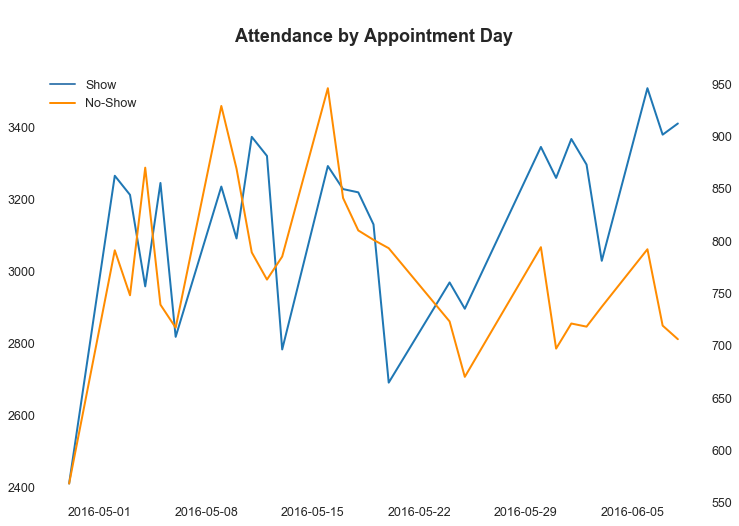

In [93]:
no_shows_weekdays = no_shows[no_shows['Weekend'] == 0]
shows_weekdays = shows[shows['Weekend'] == 0]

# Number of no-shows, shows by appointment day - excluding weekends
no_shows_by_day = no_shows_weekdays.groupby('AppointmentDay')['AppointmentDay'].count()
shows_by_day = shows_weekdays.groupby('AppointmentDay')['AppointmentDay'].count()

# Exclude weekends and weekdays with no appointments
fig, ax1 = plt.subplots(figsize = (12, 8))
ax2 = ax1.twinx()

ax1.plot(shows_by_day, linewidth = 2)
ax2.plot(no_shows_by_day, linewidth = 2, color = 'darkorange')

# cannot despine, it moves the second y-axis to the left
dirs = ['bottom', 'top', 'right', 'left']

for d in dirs:
    ax1.spines[d].set_color('white')
    ax2.spines[d].set_color('white')
    
custom_lines = [Line2D([0], [0], color = 'steelblue', lw=2),
                Line2D([0], [0], color = 'darkorange', lw=2)]
ax1.legend(custom_lines, ['Show', 'No-Show'])

plt.title('\nAttendance by Appointment Day\n', fontsize = 18, fontweight = 'bold')
plt.xlabel('');

The number of shows was greater over the first two weeks, and at around May 22, started to climb again.  However during the last three weeks, no-shows were much lower than they were during the first two weeks.

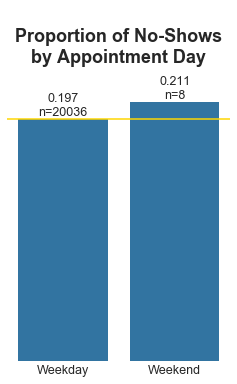

In [94]:
fig, ax = plt.subplots(figsize = (4, 5))
sns.barplot(x = 'Weekend', y = 'prop', data = no_show_props['Weekend'], color = '#1f77b4');

ax.set(xticklabels = ['Weekday', 'Weekend'])
sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
plt.axhline(y=no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['Weekend'][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No-Shows\nby Appointment Day\n', fontsize = 18, fontweight = 'bold');

Weekend appointments are more likely to result in no-shows, however only 38 weekend appointments were made, with 8 of those resulting in no-shows, so it is difficult to make concrete conclusions.

#### Scheduled Hour

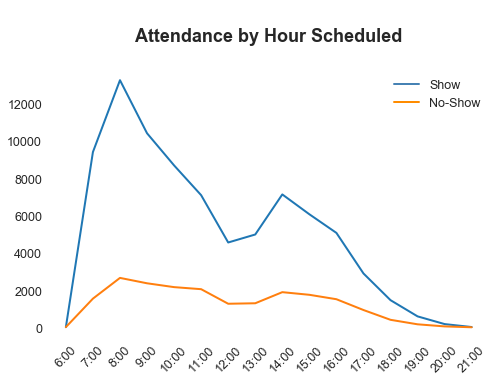

In [95]:
fig, ax = plt.subplots(figsize = (8, 5))

plt.plot(shows['ScheduledHour'].value_counts().sort_index(), linewidth = 2)
plt.plot(no_shows['ScheduledHour'].value_counts().sort_index(), linewidth = 2)
sns.despine(left = True, bottom = True)

custom_lines = [Line2D([0], [0], color = 'steelblue', lw=2),
                Line2D([0], [0], color = 'darkorange', lw=2)]
ax.legend(custom_lines, ['Show', 'No-Show'])

formatted_hours = [str(hour) + ':00' for hour in range(6, 22)]
plt.xticks(np.arange(6, 22, 1), rotation = 45)
ax.set(xticklabels=formatted_hours)
plt.title('\nAttendance by Hour Scheduled\n', fontsize = 18, fontweight = 'bold');

The number of no-shows seems to follow the same pattern as the number of shows, but much more dampened down; the number of attended apointments per hour has much greater variability than the number of no-shows.

#### Neighborhood

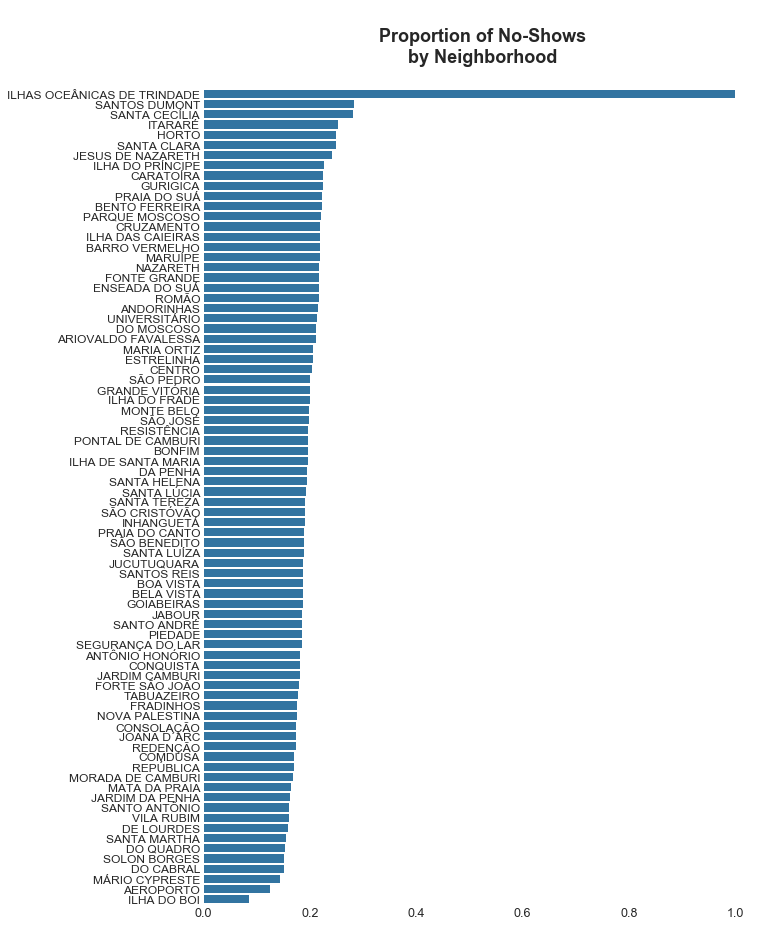

In [96]:
no_show_props['Neighborhood'] = no_show_props['Neighborhood'].sort_values(by = 'prop', ascending = False)

fig, ax = plt.subplots(figsize = (10, 15))
sns.barplot(x = 'prop', y = 'Neighborhood', data = no_show_props['Neighborhood'], color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.yticks(fontsize = 12)
plt.xlabel('')
plt.ylabel('')
    
plt.title('\nProportion of No-Shows\nby Neighborhood\n', fontsize = 18, fontweight = 'bold');

In [97]:
# there were only two appointments at this location and they were both no-shows
df[df['Neighborhood'] == 'ILHAS OCEÂNICAS DE TRINDADE']

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,...,DayOfWeek,Weekend,NumTimesScheduled,DaysBWScheduling,DayBWBin,WasRescheduled,NumSchedBin,Show,PriorAttendanceRecord,ShowsInARow
48581,534986855114,5583947,1,2016-04-14 12:25:43,2016-05-13,51,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,...,4,0,1,0.0,0,0,0,0,NaN,0
69746,7256429752481,5583948,1,2016-04-14 12:26:13,2016-05-13,58,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,...,4,0,1,0.0,0,0,0,0,NaN,0


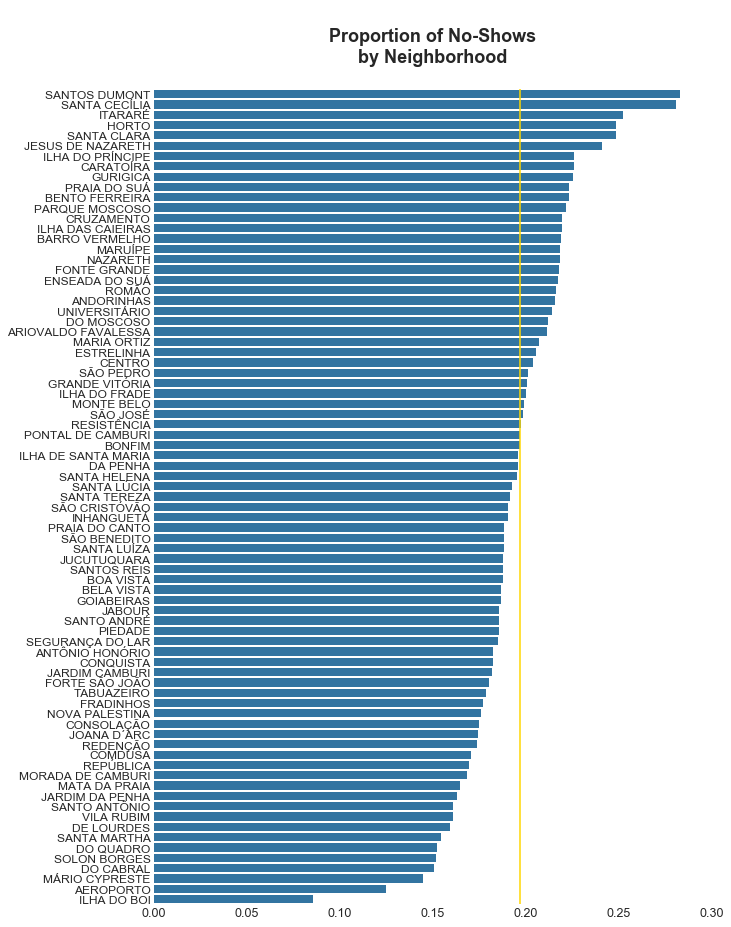

In [98]:
# Do not include ILHAS OCEÂNICAS DE TRINDADE in plot
no_show_props_to_plot = no_show_props['Neighborhood'][no_show_props['Neighborhood']\
                                                      ['Neighborhood'] != 'ILHAS OCEÂNICAS DE TRINDADE']
no_show_props_to_plot = no_show_props_to_plot.sort_values(by = 'prop', ascending = False)

fig, ax = plt.subplots(figsize = (10, 15))
sns.barplot(x = 'prop', y = 'Neighborhood', data = no_show_props_to_plot, color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0, 0.35, 0.05))
plt.axvline(x=no_show_rate, color = 'gold')

plt.title('\nProportion of No-Shows\nby Neighborhood\n', fontsize = 18, fontweight = 'bold');

About half of the neighborhoods have a greater rate of no-shows than the overall no-show rate.

#### Days Between Scheduling and Appointment

In [99]:
# Create a column for the sorting order
no_show_props['DayDiffBin']['sort_order'] = no_show_props['DayDiffBin']['DayDiffBin'].map(day_diff_sorter)
no_show_props['DayDiffBin'].sort_values(by = 'sort_order')
no_show_props['DayDiffBin']

,DayDiffBin,NoShow,prop,sort_order
1,0,1,0.039909,0
3,1-2,1,0.223808,1
5,11-14,1,0.310984,4
7,15-29,1,0.323276,5
9,3-5,1,0.237617,2
11,30-59,1,0.332262,6
13,6-10,1,0.266859,3
15,60+,1,0.280899,7


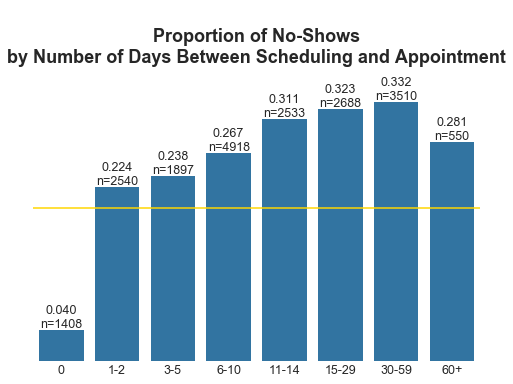

In [100]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'sort_order', y = 'prop', data = no_show_props['DayDiffBin'], color = '#1f77b4');
ax.set(xticklabels=day_diff_bin_labels)

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0
# sorter list for the count labels
day_diff_sorter_list = range(0, 8)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['DayDiffBin'][day_diff_sorter_list][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No-Shows\nby Number of Days Between Scheduling and Appointment\n',
          fontsize = 18, fontweight = 'bold');

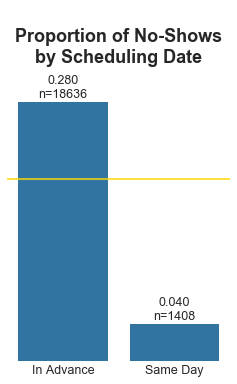

In [101]:
fig, ax = plt.subplots(figsize = (4, 5))
sns.barplot(x = 'SameDayAppt', y = 'prop', data = no_show_props['SameDayAppt'], color = '#1f77b4');
ax.set(xticklabels=['In Advance', 'Same Day'])

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0
# sorter list for the count labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.005,
            '{:0.3f}\nn={}'.format(height, freqs_labels['SameDayAppt'][j]),
            ha="center")
    j +=1

plt.title('\nProportion of No-Shows\nby Scheduling Date\n',
          fontsize = 18, fontweight = 'bold');

Perhaps one of the most glaring differences in no-show rates is between appointments scheduled on the same day as the appointment, and those scheduled at least a day in advance.  If a patient is trying to make an appointment for that same day it is probably urgent, which explains the low no-show rate.  There are also higher rates of no-shows for appointments made more than ten days in advance.  

#### Number of Times an Appointment was Scheduled

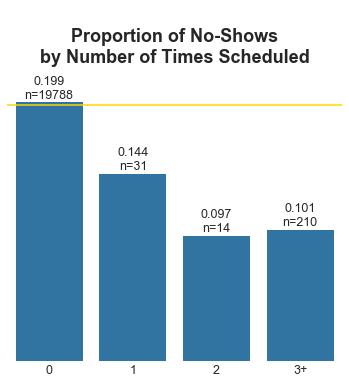

In [102]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.barplot(x = 'NumSchedBin', y = 'prop', data = no_show_props['NumSchedBin'], color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['NumSchedBin'][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No-Shows\nby Number of Times Scheduled\n',
          fontsize = 18, fontweight = 'bold');

#### Days Between Rescheduling

In [103]:
# Create a column for the sorting order
no_show_props['DayBWBin']['sort_order'] = no_show_props['DayBWBin']['DayBWBin'].map(day_bw_sorter)
no_show_props['DayBWBin'].sort_values(by = 'sort_order')
no_show_props['DayBWBin']

,DayBWBin,NoShow,prop,sort_order
1,0,1,0.200392,0
3,1-2,1,0.125000,2
5,11-14,1,0.113879,5
7,15-29,1,0.106830,6
9,3-5,1,0.087179,3
11,30+,1,0.100515,7
13,6-10,1,0.099119,4
15,<1,1,0.168690,1


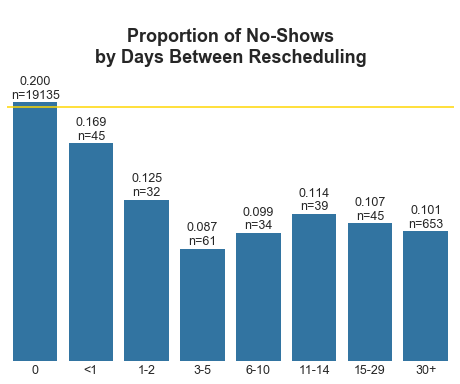

In [104]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = 'sort_order', y = 'prop', data = no_show_props['DayBWBin'], color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=day_bw_labels)
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')
j = 0

day_bw_sorter_list = range(0, 8)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['DayBWBin'][day_bw_sorter_list][j]),
            ha="center")
    j +=1
    
plt.title('\nProportion of No-Shows\nby Days Between Rescheduling\n',
          fontsize = 18, fontweight = 'bold');

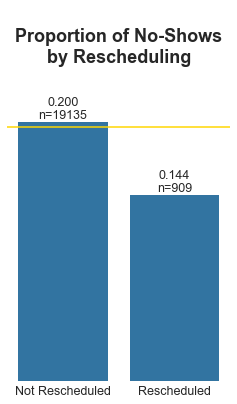

In [105]:
fig, ax = plt.subplots(figsize = (4, 5))
sns.barplot(x = 'WasRescheduled', y = 'prop', data = no_show_props['WasRescheduled'], color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.set(xticklabels=['Not Rescheduled', 'Rescheduled'])
ax.set(yticklabels='')
ax.axhline(y = no_show_rate, color = 'gold')

j = 0

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.003,
            '{:0.3f}\nn={}'.format(height, freqs_labels['WasRescheduled'][j]),
            ha="center")
    j +=1

plt.title('\nProportion of No-Shows\nby Rescheduling\n\n',
          fontsize = 18, fontweight = 'bold');

The appointments that were rescheduled have much lower rates of non-attendance than those that were not rescheduled. Attendance rates are best for the appointments that were rescheduled over a period of 3-5 days.

#### Prior Attendance Record

In [106]:
df['PriorAttendanceRecord'].describe()

count    39505.000000
mean         0.778644
std          0.365464
min          0.000000
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: PriorAttendanceRecord, dtype: float64

In [107]:
# Merge the proportions of no-shows for PriorAttendanceRecord, with the counts of each proportion
prior_attd_counts = pd.DataFrame(df['PriorAttendanceRecord'].value_counts())
prior_attd_weights = no_show_props['PriorAttendanceRecord'].merge(right = prior_attd_counts,
                                                                  left_on = 'PriorAttendanceRecord', 
                                                                  right_index = True)
prior_attd_weights = prior_attd_weights.drop('PriorAttendanceRecord_x', axis = 1)
prior_attd_weights = prior_attd_weights.rename(columns = {'PriorAttendanceRecord_y': 'count'}).reset_index(drop=True)
prior_attd_weights.head()

,PriorAttendanceRecord,NoShow,prop,count
0,0.000000,1,0.262479,5890
1,0.200000,1,0.476190,21
2,0.222222,1,1.000000,2
3,0.250000,1,0.317073,82
4,0.285714,1,0.600000,5


Each unique value for PriorAttendanceRecord is represented by one point, but I wanted to include a stronger weighting for those records that have more datapoints.  So I made the size of the point equal to the square root of the number of datapoints with that attendance record.  There is a large range in the counts, so I used the square root to dampen it, so there would not be such a stark difference in the size of the points.  However it is important to keep in mind, that the vast majority of points have a PriorAttendanceRecord of 0, 0.5, or 1.

In [108]:
prior_attd_weights['sq_rooted'] = prior_attd_weights['count'].pow(0.5)

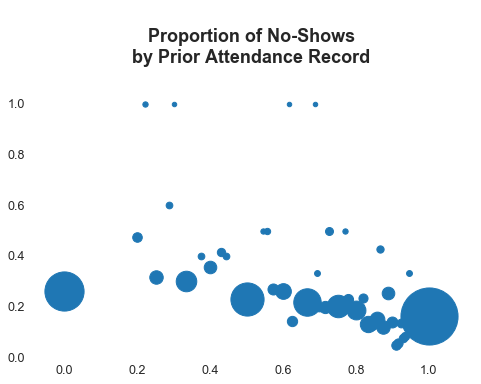

In [109]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
plt.title('\nProportion of No-Shows\nby Prior Attendance Record\n', fontsize = 18, fontweight = 'bold');

for i in range(0, len(prior_attd_weights)):
    plt.scatter(prior_attd_weights.loc[i, 'PriorAttendanceRecord'],
                prior_attd_weights.loc[i, 'prop'],
                s = prior_attd_weights.loc[i, 'sq_rooted']*20,
                color = '#1f77b4')

In [110]:
pearsonr(prior_attd_weights['PriorAttendanceRecord'], prior_attd_weights['prop'])

(-0.50895508007576973, 0.00041879014581853411)

We can see that there is a moderately strong negative relationship, with a correlation of -0.509, between PriorAttendanceRecord and the proportion of no-shows.  As the PriorAttendanceRecord improves, the proportion of of no-shows decreases.

#### Shows In a Row

In [111]:
df['ShowsInARow'].describe()

count    101803.000000
mean          0.454053
std           1.170600
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
Name: ShowsInARow, dtype: float64

In [112]:
df[df['ShowsInARow'] > 0]['ShowsInARow'].describe()

count    26593.000000
mean         1.738202
std          1.736013
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         25.000000
Name: ShowsInARow, dtype: float64

In [113]:
no_show_props['ShowsInARow'] = no_show_props['ShowsInARow'].reset_index(drop = True)
no_show_props['ShowsInARow']

,ShowsInARow,NoShow,prop
0,0,1,0.208855
1,1,1,0.173402
2,2,1,0.162275
3,3,1,0.143084
4,4,1,0.114691
5,5,1,0.090186
6,6,1,0.072072
7,7,1,0.122449
8,8,1,0.044444
9,9,1,0.083333


In [114]:
# Fill in holes for number of shows in a row that have 0% no-shows
in_a_row_props = [[i, 0] for i in range(16, 26)]
in_a_row_props.remove([23, 0]) # there is already a row for 23 in a row
in_a_row_props_df = pd.DataFrame(in_a_row_props, columns = ['ShowsInARow', 'prop'])

# Add in the filled in parts
no_show_props['ShowsInARow'] = no_show_props['ShowsInARow'].append(in_a_row_props_df, ignore_index = True)

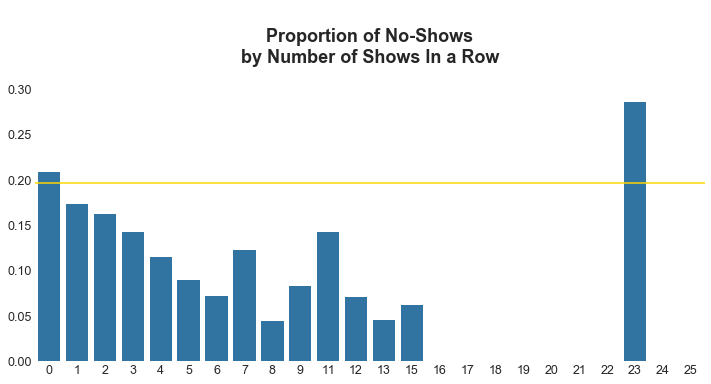

In [115]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(x = 'ShowsInARow', y = 'prop', data = no_show_props['ShowsInARow'], color = '#1f77b4');

sns.despine(left = True, bottom = True)
plt.xlabel('')
plt.ylabel('')
ax.axhline(y = no_show_rate, color = 'gold')

plt.title('\nProportion of No-Shows\nby Number of Shows In a Row\n',
          fontsize = 18, fontweight = 'bold');

Apart from 23 shows in a row, for the most part as the number of attended appointments in a row increases, the rate of no-shows decreases.  Basically, the patients that attend multiple appointments in a row are more likely to attend future appointments.  However, most patients either do not have prior appointments or missed their last appointment, so they have zero shows in a row.  Among patients that have at least one attended appointment, at least 50% have only attended one appointment.

#### Weather

##### Precipitation

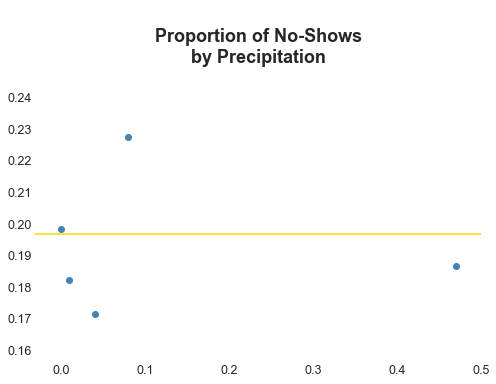

In [116]:
# By attendance - precipitation plot
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(x = 'precip_in', y = 'prop', data = no_show_props['precip_in'], color = 'steelblue');

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.ylabel('')
ax.axhline(y = no_show_rate, color = 'gold')

plt.title('\nProportion of No-Shows\nby Precipitation\n',
          fontsize = 18, fontweight = 'bold');

There were only five days with precipitation, which is not enough to detect a pattern.  It may be worth noting that even the day with the greatest amount of rain had a lower rate of no-shows than the overall rate.

##### Rain, Thunderstorms, and Fog

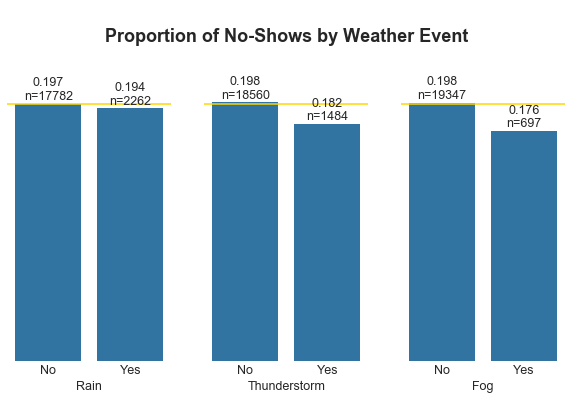

In [132]:
weather_fields = ['rain', 'thunderstorm', 'fog']
xlabels = ['Rain', 'Thunderstorm', 'Fog']
fig, axes = plt.subplots(1, 3, figsize = (10, 5), sharey = True)

i = 0
for ax in axes.reshape(-1):
    sns.barplot(ax = ax, x = weather_fields[i], y = 'prop', hue = 'NoShow', data = no_show_props[fields[i]]);
    sns.set_style("white")
    ax.tick_params(length = 0)
    ax.legend_.remove()
    sns.despine(left = True, bottom = True)
    ax.set(yticklabels='')
    ax.set(xlabel = xlabels[i], ylabel = '')
    ax.set(xticklabels=['No', 'Yes'])
    ax.set(xlabel = xlabels[i], ylabel = '')
    ax.axhline(y = no_show_rate, color = 'gold')
    if i == 1:
        ax.set_title('\nProportion of No-Shows by Weather Event\n\n', fontsize = 18,
                     fontweight = 'bold')

    j = 0
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.003,
                #'{:0.3f}'.format(height),
                '{:0.3f}\nn={}'.format(height, freqs_labels[weather_fields[i]][j]),
                ha="center")
        j += 1
    i += 1

plt.show()

Although there were only six instances of rain, two of thunderstorms, and one of fog, there were fairly large differences in the no-show rates for days with thunderstorms or fog.  It is interesting to note that even on these rare occassions of inclement weather, the rate of skipping appointments actually decreased.

##### Temperature

In [ ]:
# rearrange temperature data so that it can be joined and plotted according to type
temp_fields = ['temp_low', 'temp_high', 'temp_avg']

for field in temp_fields:
    no_show_props[field] = no_show_props[field].rename(columns = {field: 'temp'})
    no_show_props[field]['Temperature'] = field.split('_')[1]
    
temps = pd.concat([no_show_props['temp_low'], no_show_props['temp_avg'], no_show_props['temp_high'], ])
temps.head()

In [ ]:
# By attendance - temperatures plot
sns.lmplot(x = 'temp', y = 'prop', data = temps, hue = 'Temperature',
           fit_reg = False, ci = None, size = 7, aspect = 1.6);

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('\nDegrees Fahrenheit')
plt.ylabel('')

plt.title('\nProportion of No-Shows\nby Daily Temperature\n',
          fontsize = 18, fontweight = 'bold');

In [ ]:
pearsonr(no_show_props['temp_low']['temp'], no_show_props['temp_low']['prop'])

In [ ]:
pearsonr(no_show_props['temp_high']['temp'], no_show_props['temp_high']['prop'])

In [ ]:
pearsonr(no_show_props['temp_avg']['temp'], no_show_props['temp_avg']['prop'])

We can see from the plots and the correlation coefficents, and their accompanying p-values, that there is no relationship between temperature and appointment no-shows.

##### Humidity

In [ ]:
# rearrange humidity data so that it can be joined and plotted according to type
humidity_fields = ['humidity_low', 'humidity_avg', 'humidity_high']

for field in humidity_fields:
    no_show_props[field] = no_show_props[field].rename(columns = {field: 'humid'})
    no_show_props[field]['Humidity'] = field.split('_')[1]
    
humidity = pd.concat([no_show_props['humidity_low'], no_show_props['humidity_avg'], no_show_props['humidity_high']])
humidity.head()

In [ ]:
# By attendance - humidity plot
sns.lmplot(x = 'humid', y = 'prop', data = humidity, hue = 'Humidity',
           fit_reg = False, ci = None, size = 7, aspect = 1.6);

sns.despine(left = True, bottom = True)
plt.xticks(rotation = 0)
plt.xlabel('\nPercent Humidity')
plt.ylabel('')

plt.title('\nProportion of No-Shows\nby Daily Humidity\n\n',
          fontsize = 18, fontweight = 'bold');

The daily humidity levels show even less of a relationship than the temperatures.  From these plots we can conclude that weather information would not be useful for modeling appointment no-shows.

<a id='sms'></a>

### Investigating SMSReceived

Earlier we saw that strangely the rate of no-shows was greater for those patients that received a text reminder about their appointment.  Almost 35% of the appointments were scheduled on the same day, and the system probably does not have time to send reminders for an appointment that is scheduled with so little advance notice.

In [ ]:
sms_fields = ['DayDiff', 'DayDiffBin', 'SameDayAppt']

# create dictionary of dataframes of proportions of SMSReceived for each field
sms_props = {}
for field in sms_fields:
    counts = df.groupby([field,'SMSReceived'])['SMSReceived'].count()
    totals = df.groupby(field)['SMSReceived'].count()
    sms_props[field] = (counts/totals).rename('prop').reset_index()

In [ ]:
fig, ax = plt.subplots(figsize = (6, 5))
sns.barplot(ax = ax, x = 'SameDayAppt', y = 'prop', hue = 'SMSReceived', data = sms_props['SameDayAppt'].reset_index())
sns.despine(left = True, bottom = True)
ax.set(xticklabels= ['In Advance', 'Same Day'])
plt.xlabel('')
plt.ylabel('')
lengend = plt.legend()
lengend.get_texts()[0].set_text('Reminder Not Sent')
lengend.get_texts()[1].set_text('Reminder Sent')
plt.title('\nProportion of SMS Received\nby Scheduling Date\n',
          fontsize = 18, fontweight = 'bold');

In the plot above we can see that text reminders were sent for almost exactly half of the appointments made in advance, but none were sent for the same day appointments.

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(ax = ax, x = 'DayDiffBin', y = 'prop', hue = 'SMSReceived', data = sms_props['DayDiffBin'].reset_index())
sns.despine(left = True, bottom = True)
ax.set(xticklabels= day_diff_bin_labels)
plt.xlabel('')
plt.ylabel('')
lengend = plt.legend()
lengend.get_texts()[0].set_text('Reminder Not Sent')
lengend.get_texts()[1].set_text('Reminder Sent')
plt.title('\nProportion of SMS Received\nby Number of Days between Scheduling and Appointment\n',
          fontsize = 18, fontweight = 'bold');

In [ ]:
sms_props['DayDiff'].head(9)

The facilities in Vitória did not send any reminders for appointments that were scheduled less than three days in advance of the appointment day.  We can also see that as the number of days leading up to the appointment increases, the proportion of SMS reminders sent increases.

In [135]:
day_diff_three = df[df['DayDiff'] >= 3]

In [136]:
day_diff_three.groupby(['SMSReceived', 'NoShow'])['NoShow'].count()/\
    day_diff_three.groupby(['SMSReceived'])['NoShow'].count()

SMSReceived  NoShow
0            0         0.677660
             1         0.322340
1            0         0.728679
             1         0.271321
Name: NoShow, dtype: float64

We can see that if we restrict the data to only those with a difference of three days or greater between the scheduling and the appointment that the no-show rate is greater for those that did not receive a reminder text.

In [ ]:
counts = no_shows.groupby(['DayDiffBin','SMSReceived'])['NoShow'].count()
totals = df.groupby('DayDiffBin')['NoShow'].count()

day_diff_props = pd.DataFrame(counts/totals).reset_index()

fig, ax = plt.subplots(figsize = (12, 5))
sns.barplot(ax = ax, x = 'DayDiffBin', y = 'NoShow', hue = 'SMSReceived', data = day_diff_props)
sns.despine(left = True, bottom = True)
ax.set(xticklabels= day_diff_bin_labels)
plt.xlabel('')
plt.ylabel('')
lengend = plt.legend()
lengend.get_texts()[0].set_text('Reminder Not Sent')
lengend.get_texts()[1].set_text('Reminder Sent')
plt.title('\nProportion of No-Shows\nby Number of Days between Scheduling and Appointment\n',
          fontsize = 18, fontweight = 'bold');

However, if we break down the no-show rates by SMS reminder and the number of days between scheduling and appointment we see an example of Simpson's paradox; while overall the no-show rate is lower with a reminder, each scheduling group shows a greater rate of skipping.

<a id='inference'></a>

## Statistical Inference
***

There were quite a few variables that showed a significant difference in no-show rates between their classes.  I will be using hypothesis testing so that I may be able to make conclusions about whether these differences are statitiscally significant.  

I will be using a chi-square test for the difference between two proportions.

The null hypothesis ($H_0$) is that there there is no difference between the two population proportions of no-shows for each of the two classes.  The alternative hypothesis ($H_A$) is that the differences in the two population proportions of no-shows are not by chance, and that one is less than the other.

$$H_0:  P_1 = P_2$$
$$H_A:  P_1 < P_2$$

The values of $P_1$ and $P_2$ depend on the variable being tested, and are shown in the table below.

Since I will be conducting multiple tests, in order to control the familywise error rate, or the likelihood of making at least one type I error, I will be using the Bonferroni correction.  I will be conducting 8 experiments, with an overall significance level $\alpha$ of 0.05, so the significance level for each individual experiment is ${{0.05}\over{10}} = 0.005$.

The variables that I will be testing are:
    - BolsaFamilia
    - Alcoholism
    - Diabetes
    - Hypertension
    - SMSReceived (only when the appointment was scheduled at least 3 days in advance, i.e. DayDiff >= 3) 
    - HasHandicaps
    - SameDayAppt
    - WasRescheduled
    - thunderstorm
    - fog
    
For the groups above, the samples are independent and there is a frequency of at least five in each of the cells of the contingency table.

| Variable  | Null Hypothesis  | Alternative Hypothesis  |
|---|---|---|
| BolsaFamilia  | $$P_{no} = P_{yes}$$  | $$P_{no} < P_{yes}$$  |
| Alcoholism  | $$P_{no} = P_{yes}$$  |  $$P_{no} < P_{yes}$$ |
| Diabetes  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| Hypertension  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| SMSReceived  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| HasHandicaps  | $$P_{no} = P_{yes}$$  |  $$P_{no} < P_{yes}$$ |
| SameDayAppt  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| WasRescheduled  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| thunderstorm  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |
| fog  | $$P_{yes} = P_{no}$$  |  $$P_{yes} < P_{no}$$ |

In [143]:
# Chi-square test
chi2_dict = {}

# Make contingency table for SMSReceived when DayDiff > 3
counts = day_diff_three.groupby(['SMSReceived','NoShow'])['NoShow'].count()
no_show_freqs['SMSReceived_DayDiff3'] = np.array(counts.sort_index(ascending = False)).reshape(2,2)

# Pass contingency table for each field to chi-square test
testing_fields = ['BolsaFamilia', 'Alcoholism', 'Diabetes', 'Hypertension',
                  'SMSReceived_DayDiff3', 'HasHandicaps', 'SameDayAppt', 'WasRescheduled',
                  'thunderstorm', 'fog']
for field in testing_fields:
    # Use Yate's correction since dof = 1
    chi2_dict[field] = chi2_contingency(no_show_freqs[field].reshape(2,2), correction=True)

# Assemble results of chi-square tests into a dataframe
chi2_test = pd.DataFrame(chi2_dict, index = ['statistic', 'p-value', 'dof', 'exp_freq']).T
chi2_test = chi2_test.drop(['exp_freq', 'dof'], axis = 1)

# Use Bonferroni correction
overall_alpha = 0.05
num_tests = len(testing_fields)
ind_alpha = overall_alpha/num_tests

chi2_test['Significant?'] = np.where(chi2_test['p-value'] < ind_alpha, 'Yes', 'No')
chi2_test

,statistic,p-value,Significant?
Alcoholism,5.07551,0.0242662,No
BolsaFamilia,86.3654,1.49578e-20,Yes
Diabetes,24.8621,6.15823e-07,Yes
HasHandicaps,9.99349,0.00157094,Yes
Hypertension,138.482,5.71585e-32,Yes
SMSReceived_DayDiff3,166.57,4.15254e-38,Yes
SameDayAppt,8412.65,0,Yes
WasRescheduled,119.006,1.0439e-27,Yes
fog,11.0199,0.000901409,Yes
rain,0.872177,0.350353,No


For all of the variables apart from Alcoholism, there is enough evidence to reject the null hypothesis.

<a id='conclusion'></a>

## Conclusion
***

From the table of results above, we can see that there is a statistically significant difference in the no-show rates for the two classes of each of the variables, apart from Alcoholism, since they all have a p-value less than $\alpha$ = 0.00625.  These variables would most likely be very useful for building a model that predicts appointment no-shows.  Any other relationships founds in the analysis are tentative, and without hypothesis testing cannot be confirmed.

Although many variables and relationships were explored in this analysis, besides SMSReceived and NoShow, interactions between variables were not fully investigated.  Additionally, correlations and any collinearity was also not explored, which would be important to dive into before creating a classifier.